In [1]:
# import libaries
import matplotlib.pyplot as plt
from IPython import display
import matplotlib as mpl
from matplotlib import cm
import geopandas as gpd
import pandas as pd
import math
import json
import numpy as np
from sqlalchemy import create_engine
import bisect
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

# Database Connection

You can set up the database connection using a JSON file that contains your credentials. Place the file with the name 'credentials.json' under the path 'config/credentials.json', relative to this notebook.

Your JSON file should have the following structure:

{<br>
"username": "your_username",<br>
"password": "your_password",<br>
"host": "your_host",<br>
"port": "your_port",<br>
"database_name": "v2g"<br>
}<br>

**Important:** Please note that if you are using GitHub, make sure to check the .gitignore file to prevent the credential file from being committed, as this repository is public!

In [2]:
# load the credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


# Electricitiy Prices (will be replaced with real data later)

In [3]:
electricity_price = np.zeros(96)
electricity_price[:24] = 0.2
electricity_price[24:40] = 0.25
electricity_price[40:44] = 0.22
electricity_price[44:56] = 0.2
electricity_price[56:68] = 0.22
electricity_price[68:84] = 0.25
electricity_price[84:] = 0.22

In [ ]:
# Enviorment (will be replaced with Python package later)

In [52]:
class CarsharingEnv(gym.Env):
    def __init__(self, stations, vehicle_information, episode_len = 24, dt=0.25, 
                 cancellation_penalty = 100, penalty_per_kwh = 0.25, v2g = True, 
                 v2g_demand_event = 500, v2g_max_duration = 3.0, v2g_penalty = 10000, 
                 v2g_probability_charging_event = 0.5, v2g_probability_discharging_event = 0.5, 
                 v2g_morning_time_period = [6.0, 9.0, 10.75], v2g_noon_time_period = [11.0, 14.0, 16.0], 
                 v2g_evening_time_period = [16.25, 19.0, 24.0], v2g_reward = 2000,
                 planned_bookings = True, max_distance_car_assingment = 5000, plot_state = True):
        """
        Parameters
        ----------
        stations: Geopandas Geodataframe
            Locations of car-sharing stations, including a distinct "station_no" attribute with station ID.
        vehicle_information: Pandas Dataframe
            Includes the features "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category" for each car.
        episode_len: int, optional
            Length of one episode in hours, by default 24.
        dt: float, optional
            Time step size in hours, by default 0.25 (a quarter hour).
        cancellation_penalty: int, optional
            Maximum penalty in CHF for a booking cancelled due to not enough charged battery, by default 100.
        penalty_per_kwh: int, optional
            Penalty in CHF/kWh for total negative energy difference between beginning and ending of episode, by default 0.25.
        v2g: boolean, optional
            Boolean indicating if V2G events take place, by default True.
        v2g_demand_event: int, optional
            Energy demand during V2G event in kWh per time step (dt), by default 500.
        v2g_max_duration: int, optional
            Maximum duration of V2G charging or discharging event in hours, by default 3.
        V2G_penalty: int, optional
            Penalty in CHF if agent charges/discharges less energy than specified in "v2g_demand_event" during V2G event, by default 10000.
        v2g_probability_charging_event: float, optional
            Probability that a charging event will take place around noon, by default 0.5.
        v2g_probability_discharging_event: float, optional
            Probability that a discharging event will take place in the morning or evening, by default 0.5.
        v2g_morning_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g discharging event in the morning, by default 6.0 (6 AM).
                             2) last possible time (hours) for starting v2g discharging event in the morning, by default 9.0 (9 AM).
                             3) last possible timestamp for v2g discharging operation, by default 10.75 (10:45 AM).
        v2g_noon_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g charging event at noon, by default 11.0 (11 AM).
                             2) last possible time (hours) for starting v2g charging event at noon, by default 14.0 (2 PM).
                             3) last possible timestamp for v2g charging operation, by default 16.0 (4 PM).
        v2g_evening_time_period: list, optional
            List containing: 1) first possible time (hours) for starting v2g discharging event in the evening, by default 16.25 (4:15 PM).
                             2) last possible time (hours) for starting v2g discharging event in the evening, by default 19.0 (7 PM).
                             3) last possible timestamp for v2g charging operation, by default 24 (00:00 AM, next day).
        v2g_reward: int, optional
            Revenue during v2g operations per timestep in CHF, by default 2000 CHF.
        planned_bookings: boolean, optional
            Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.
        max_distance_car_assingment: int, optional
            Maximum search distance in meter for Car-assingment problem, by default 5000.
        plot_state: boolean, optional
            Plot current state of enviorment or not, by defualt True.
        ----------
        Observation space: 5 parts:
        1) Location for each car (three options):
            - Station number (1000-5000)
            - Reservation number (2x'xxx'xxx) during trip
            - Reservation number (3x'xxx'xxx) during relocation
            - -1 if car is not available
        2) State of charge (SOC) for each vehicle (between 0 and 1).
        3) Timestamp of the next planned booking for each car (discrete between 0 and self.episode_len).
        4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
        5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
        Remark: States 3) and 4) are only included if the variable "planned_bookings" is True.
        ----------
        Action space: 3 actions for each car:
        1) 0 = do nothing.
        2) 1 = charging.
        3) 3 = discharging (V2G).
        """
        # environment settings
        self.dt = dt
        self.episode_len = int(episode_len / self.dt) 
        self.planned_bookings = planned_bookings
        self.max_distance_car_assingment = max_distance_car_assingment
        self.plot_state = plot_state
        
        # stations in system
        self.stations = stations
        
        # vehicle information
        self.vehicles_id = vehicle_information["vehicle_no"]
        self.nr_vehicles = len(self.vehicles_id)
        self.chariging_power = vehicle_information["charge_power"]
        self.battery_capacities = vehicle_information["battery_capacity"] 
        self.vehicle_type = vehicle_information["vehicle_category"] 
        
        # V2G 
        self.v2g = v2g
        self.v2g_demand_event = v2g_demand_event
        self.v2g_max_duration = v2g_max_duration / self.dt
        self.v2g_penalty = v2g_penalty
        self.v2g_probability_charging_event = v2g_probability_charging_event
        self.v2g_probability_discharging_event = v2g_probability_discharging_event
        self.v2g_morning_time_period = v2g_morning_time_period
        self.v2g_noon_time_period = v2g_noon_time_period
        self.v2g_evening_time_period = v2g_evening_time_period
        self.v2g_reward = v2g_reward
        
        # penalties
        self.cancellation_penalty = cancellation_penalty
        self.penalty_per_kwh = penalty_per_kwh
        
        # define observation space:
        if self.planned_bookings is True:
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0, -1, -1] * self.nr_vehicles),
                    high=np.array([9999999, 1, 96, 100] * self.nr_vehicles),
                ),
                'v2g_event_feature': gym.spaces.Discrete(3)
            })
        else: 
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0] * self.nr_vehicles),
                    high=np.array([9999999, 1] * self.nr_vehicles)
                ),
                'v2g_event_feature': gym.spaces.Discrete(3)
            })
        
    
        # action space
        self.action_space = spaces.MultiDiscrete([3 for _ in range(self.nr_vehicles)])
        
        # define state boundaries for slicing list
        # locations upper bound
        self.locations_upper = self.nr_vehicles
        # soc upper bound
        self.soc_upper = 2*self.nr_vehicles
        if planned_bookings is True:
            # locations, upper bound:
            self.reservation_time_upper = self.nr_vehicles * 3
            self.v2g_lower = self.nr_vehicles * 4
            
            

        else:
            # locations, upper bound:
            self.v2g_lower = self.nr_vehicles * 2
            
       
        
        
        #sql = "SELECT reservation_no FROM mobility.service_reservation"
        #test = pd.read_sql(sql, engine)
        #self.test = test
        
    def reset(self, daily_data, reservations):
        """
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".

        Returns
        ----------
        self.state: numpy ndarray
            The reset state of the environment at the first time step. It includes the following information for each car:
            1) Location:
                - Station number (1000-5000)
                - Reservation number (2x'xxx'xxx) during trip
                - Reservation number (3x'xxx'xxx) during relocation
                - -1 if the car is not available
            2) State of charge (SOC) for each vehicle (between 0 and 1).
            3) Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
            4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
            5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
            Note: The information in 3) and 4) is included only if the variable "planned_bookings" is True.
        """
        
        # set time to 0
        self.t = 0
        
        # reset reward lists 
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_discharging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list_v2g = []
        self.reward_list = []
        
        # reset state
        self.state_old = np.zeros(self.nr_vehicles * 4 + 1)
        
        # reset planned reservations:
        self.planned_reservations_car = {key: [] for key in self.vehicles_id}
        
        # get random v2g events
        self.get_random_v2g_events()
        
        
        ### initialize state at t = 0 ###
        
        # 1) car locations (three options)
        car_locations = daily_data.iloc[:,0].values
        
        # 2) SOC (state of charge) ##
        car_SOC = np.random.rand(self.nr_vehicles) # random values between 0-100%
        #car_SOC = np.zeros(self.nr_vehicles) # all car batteries empty (0%)
        #car_SOC = np.full((self.nr_vehicles,), 0.2) # all car batteries at 20%
        #car_SOC = np.random.uniform(low=0.5, high=1, size=self.nr_vehicles) # All cars randomly between 50-100%
        #np.random.seed(42)
        #rng = np.random.RandomState(42)
        #car_SOC = rng.uniform(low=0.5, high=1, size=self.nr_vehicles)
        
         # state 5) Binary V2G event
        v2g_event = np.array([0])
 
        # final state with planned bookings
        if self.planned_bookings is True:
            # 3) timestamp of next planned reservation 
            # 4) Duration of next planned reservation
            next_reservation, duration_next_reservation = self.update_reservation_state(reservations, True)
            
            # concatinate states 1-5
            self.state = np.concatenate([car_locations, car_SOC, next_reservation, duration_next_reservation, v2g_event])
        else:
            self.state = np.concatenate([car_locations, car_SOC, v2g_event])
        
        # save energy at beginning of episode (relevant for reward)
        self.energy_beginning = sum(car_SOC * self.battery_capacities)

        return self.state

    def get_random_v2g_events(self):
        
        self.v2g_discharing_morning_start = -1
        self.v2g_discharing_morning_end = -1
        self.v2g_charing_noon_start = -1
        self.v2g_charing_noon_end = -1
        self.v2g_discharing_evening_start = -1
        self.v2g_discharing_evening_end = -1
        
        if self.v2g is True:
            # morning discharging event:
            if int(random.random() < self.v2g_probability_discharging_event) == 1:
                # get random start time between 6 and 9 am
                self.v2g_discharing_morning_start = round(random.uniform(self.v2g_morning_time_period[0], self.v2g_morning_time_period[1]) / 0.25) * 0.25 / self.dt
                self.v2g_discharing_morning_end = min(self.v2g_morning_time_period[2] / self.dt, self.v2g_discharing_morning_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
            
            # noon charging event
            if int(random.random() < self.v2g_probability_charging_event) == 1:
                # get random start time between 6 and 9 am
                self.v2g_charing_noon_start = round(random.uniform(self.v2g_noon_time_period[0], self.v2g_noon_time_period[1]) / 0.25) * 0.25 / self.dt
                self.v2g_charing_noon_end = min(self.v2g_noon_time_period[2] / self.dt, self.v2g_charing_noon_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
            
            # evening discharging event
            if int(random.random() < self.v2g_probability_discharging_event) == 1:
                # get random start time between 6 and 9 am
                self.v2g_discharing_evening_start = round(random.uniform(self.v2g_evening_time_period[0], self.v2g_evening_time_period[1]) / 0.25) * 0.25 / self.dt
                self.v2g_discharing_evening_end = min(self.v2g_evening_time_period[2]/ self.dt,self.v2g_discharing_evening_start + round(random.uniform(0.25, self.v2g_max_duration) / 0.25) * 0.25 / self.dt)
        
        return
    
    def update_reservation_state(self, reservations, reset):
        """
         Parameters
        ----------
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        reset: boolean, optional
            Boolean indicating whether to reset the environment or not.
            
        Returns
        ----------
        next_reservation : numpy ndarray
            Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
        duration_next_reservation : numpy ndarray
            Duration of the next planned booking (measured in the number of time steps of length self.dt).
        """

        # initalize variables if during reset of environment
        if reset is True:
            time = 0
            next_reservation = np.ones(self.nr_vehicles) * -1
            duration_next_reservation = np.ones(self.nr_vehicles) * -1
            
        # get current state of next planned reservations (timestamp and duration)
        else:
            time = self.t + 1
            next_reservation = self.state[self.soc_upper : self.reservation_time_upper]
            duration_next_reservation = self.state[self.reservation_time_upper :self.v2g_lower]
            
        # filter reservations: 
        # bookings before t = 0 have value syscreatedate_daytime = 0
        reservations_t =  reservations[reservations["syscreatedate_daytime"] == time]
        

        # iterate over all vehicles, search planned reservations
        count = 0
        for vehicle_id in self.vehicles_id:  
            # get reservation of car
            current_car = reservations_t[reservations_t["vehicle_no"] == vehicle_id]


            # remove reservations in past
            if len(self.planned_reservations_car[vehicle_id]) != 0:
                if int(self.planned_reservations_car[vehicle_id][0][0]) < self.t:
                    self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]

            # skip if no new reservation found
            if len(current_car) == 0:
                
                # if current state's reservation is in the past 
                if next_reservation[count] <  self.t and next_reservation[count] != -1:
                    
                    # check for planned reservations saved in the past
                    if len(self.planned_reservations_car[vehicle_id]) != 0:
                        # save reservation timestamp
                        next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                        # save reservation duration
                        duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

                        # remove reservation from dict with planned reservations
                        self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]

                    else:
                        # assign -1 for no planned reservation
                        next_reservation[count] = -1
                        duration_next_reservation[count] = -1
                count +=1

                continue

            for i in range(0,len(current_car)):    
                
                # get timestamp and duration of next planned reservation
                reservation_time = current_car["reservationfrom_daytime"].iloc[i]
                reservation_duration = current_car["reservation_duration"].iloc[i]
                
                # save directly if during reset of environment
                if i == 0 and reset is True:
                    # save timestamp of next reservation
                    next_reservation[count] = reservation_time

                    # save reservation duration
                    duration_next_reservation[count] = reservation_duration


                if reset is True:
                    # save directly first reseration during reset of environment
                    if i == 0 and reset is True:
                        # save timestamp of next reservation
                        next_reservation[count] = reservation_time

                        # save reservation duration
                        duration_next_reservation[count] = reservation_duration
                    
                    # save other found reservation during reset of environment in dict
                    else:
                        new_reservation = [reservation_time, reservation_duration]

                        # remain order in dict (nearest reservation in first index)
                        index = bisect.bisect_left([sublist[0] for sublist in  self.planned_reservations_car[vehicle_id]], new_reservation[0])

                        # save timestamp and duration of new but later reservations in dict
                        self.planned_reservations_car[vehicle_id].insert(index, new_reservation)
                
                else: 
                    # save found reservation environment in dict
                    new_reservation = [reservation_time, reservation_duration]
                    
                    # remain order in dict (nearest reservation in first index)
                    index = bisect.bisect_left([sublist[0] for sublist in  self.planned_reservations_car[vehicle_id]], new_reservation[0])
                    
                    # save timestamp and duration of new but later reservations in dict
                    self.planned_reservations_car[vehicle_id].insert(index, new_reservation)

            # update only if reservation is before last planned reservation
            if  reset is False and self.planned_reservations_car[vehicle_id][0][0] <  next_reservation[count]:
                # save timestamp of next reservation
                next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                # save reservation duration
                duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

                # remove reservation from dict
                self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]
                
            count += 1
        
        return next_reservation, duration_next_reservation
    
    def cancel_trips_low_SOC(self, daily_data, reservations):
        """
        Parameters
        ----------
       daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".

        Returns
        ----------
        penalty_counter: int
            Total factor of penalty for timestep.
        """

        # check if car booked or not (start of booking)
        on_trip = self.state[:self.locations_upper] > 1000000
        trip_start = self.state[:self.locations_upper] != self.state_old[:self.locations_upper]
        result = on_trip & trip_start
        on_trip_indices = np.where(result)[0].tolist()

        
        ### check if engough energy charged for booked trip (otherwise trips needs to be cancelled) ###
        
        # array with 0 for all car that do not start a new trip, otherwise 1
        soc_needed = np.zeros(len(result))
        
        # iterate over indices of cars that start a trip
        for trip_start in on_trip_indices:
            reservation_no = self.state[trip_start]
            if reservation_no >= 30000000:
                # todo: implement relocations
                pass
            else:
                try:
                    # calculate needed SOC for trip
                    soc_needed[trip_start] = reservations[reservations["reservation_no"] == reservation_no]["required_soc"].iloc[0] / 100
 
                except Exception as E:
                    print("")
                    print(E)
                    print("reservation no")
                    print(reservation_no)
                    print(self.state[trip_start])
                    print("station_no")
                    print(self.state_old[trip_start])
                    print("vehicle id")
                    print(self.vehicles_id[trip_start])
            
        # calculate difference between SOC of car at the moment and needed SOC for starting the trip
        difference_energy = self.state[self.locations_upper:self.soc_upper] - soc_needed
      
        # boolean array, True for cars with to low SOC for trip (those reservations will be cancelled)
        cancelled_trips = difference_energy < 0
        
        # booolean array, True for cars without cancelled trip
        not_cancelled_trips = np.logical_not(cancelled_trips)
        
        # convert to integer array
        not_cancelled_trips_int = not_cancelled_trips.astype(int)
        
        # calculate new SOC of cars (previous timestamps SOC minus SOC needed for trip)
        self.state[self.locations_upper:self.soc_upper] = (self.state[self.locations_upper:self.soc_upper] - soc_needed * not_cancelled_trips_int) 

        # get indices of cars with cancelled reservation because of low battery level
        indices = np.where(cancelled_trips)[0]
        
        # count number of cancellation, used for reward penalty
        penalty_counter = 0
 

        ### remove cancelled booking from discrete tables (if reservation is cancelled, the car is again available) ###
        ### assign bookings to other cars if possible ###
    
        # iterate over indices of cars with cancelled reservations
        for index in indices:
            found = False
            last_station = 0
            t = self.t
            
            # defualt car location if last location not found
            car_location = -1
            
            while not found:
                # search last station of car in bookings, replace reservation number with last location
                if t > 0:
                    car_location = daily_data.iloc[index, t]
                    if car_location >= 1000 and car_location <= 6000:
                        found = True
                        
                        # assign cancelled reservation to other avaiable car if possible, get cancellation penalty
                        penalty_counter += self.car_assignment(car_location, daily_data, reservations, index, soc_needed)
                else:
                    # if no station found back in time, stop loop
                    found = True
                t = t - 1
                
            # update current state of car with actual location
            self.state[:self.locations_upper][index] = car_location
            
            # remove reservation from dataset
            changed = False

            # iterate over row in discrete table of given car
            for col_index, col_data in enumerate(daily_data.iloc[index]):

                
                # remove reservation, replace reservation number by car location
                if col_index >= self.t + 1 and daily_data.iloc[index, col_index] >= 1000000:
                    daily_data.iat[index, col_index] = car_location
                    changed = True
                
                # stop loop if reservation cancelled
                elif col_index >= self.t and daily_data.iloc[index, col_index] < 1000000 and changed == True:
                    break
        
        # return total cancellation penalty
        return penalty_counter
    
    def car_assignment(self, station_id, daily_data, reservations, index_car, soc_needed):
        """
        Parameters
        ----------
        station_id: int
            ID of station with the cancelled reservation.
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".
        index_car: int
            Index of the car with the cancelled reservaton
        soc_needed: int
            Minimum needed SOC for cancelled trip.

        Returns
        ----------
        penalty_counter: int
            Penalty of single cancelled reservation
        """

        # create local copy of station table
        stations_processing = self.stations.copy()
        
        #################### todo: problem at 23:45 timestamp ####################################

        # look for cars at the same station as cancelled reservation
        filtered_df = daily_data.loc[daily_data.iloc[:, self.t + 1] == station_id]
        
        # get cancelled reservation
        # if end of day (00:00)
        reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index_car]) & (reservations["reservation_no"] == daily_data.iloc[index_car, self.t + 1])]
       
        # if no reservation found
        if len(reservations_of_car) == 0:
            print("")
            print("Reservation in Discrete table not found in Reservation table")
            print("Station ID")
            print(station_id)
            print("Car ID")
            print(self.vehicles_id[index_car])
            print("Reservation_number")
            print(daily_data.iloc[index_car, self.t + 1])
   
            
            # return zero penalty
            return 0
        
        # get cancelled reservation duration
        reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
        
        # get cancelled reservation number
        reservation_no = reservations_of_car["reservation_no"].iloc[0]
        
        # get geodata of station with cancelled reservation
        station = stations_processing[stations_processing["station_no"] == station_id]
        
        # car type of cancelled car
        car_type_cancelled = self.vehicle_type[index_car]
        
        # search available cars at stations in the neigbourhood of the cancelled reservation's car
        solution_found = False
        while solution_found is not True:
            # perform the nearest neighbor join for getting nearest distance
            joined = gpd.sjoin_nearest(station, stations_processing, distance_col = "distance_stations", max_distance = self.max_distance_car_assingment)
            
            # no station found within 5km distance
            if len(joined) == 0:
                solution_found = True
                
                # return maximum penalty
                penalty = 1
                break
                
            # get station ID of nearest found station
            alternative_station_ID = joined["station_no_right"].iloc[0]
            
            # get IDs of cars at nearest found station
            cars_at_found_station = self.state[:self.locations_upper] == alternative_station_ID
            indices = np.where(cars_at_found_station)[0] 
            
            # iterate over found cars
            for index in indices:
                number_reservations = 0
                if self.planned_bookings is True:
                    # search for reservations during time period of cancelled reservation
                    reservations_of_found_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index]) & (reservations["reservationfrom_daytime"] >= self.t + 1) & (reservations["reservationfrom_daytime"] <= self.t + 1 + reservation_duration) & (reservations["syscreatedate_daytime"] <= self.t + 1)] 
                    number_reservations = len(reservations_of_found_car)

                # if alternative car available (no reservation yet) and SOC high enough for trip
                if number_reservations == 0 and (self.state[self.locations_upper:self.soc_upper][index] - soc_needed[index_car]) >= 0 and self.state[:self.locations_upper][index] >= 1000 and self.state[:self.locations_upper][index] <= 1000000 and car_type_cancelled == self.vehicle_type[index]:
                    solution_found = True
                    changed = False
                    
                    # calculate distance weighted penalty (zero if car aviailable at the same station)
                    penalty = joined["distance_stations"].iloc[0]/5000 
                    
                    # update discrete table of found car 
                    for col_index, col_data in enumerate(daily_data.iloc[index]):
                        
                        ############ overlapping if reservation only in discrete table? ############
                        
                        # add reservation to discrete table
                        if col_index > self.t + 1 and col_index <= self.t + 1 + reservation_duration:
                            daily_data.iat[index, col_index] = reservation_no                    
                    
                        # add SOC to discrete table
                        elif col_index == self.t + 1:
                            daily_data.iat[index, col_index] = reservation_no     

                            # remove used SOC during trip from vehicle state
                            self.state[self.locations_upper+ index] = (self.state[self.locations_upper + index] - soc_needed[index_car]) 
                        
                            # update state
                            self.state[index] = reservation_no
                            
                            
                        # end of reservation time period
                        elif col_index > self.t + 1 + reservation_duration:
                            break
                            
                    # stopp searching for alternative car if a solution is already found
                    break
                    
            # remove already checked station for next iteration
            if len(joined) != 0:
                stations_processing = stations_processing[stations_processing.station_no != joined["station_no_right"].iloc[0]]
                                
        # return penalty of cancellation
        return penalty
    
    def charging(self, action, not_chargable):
        
        ############ todo: implement charging function ############
    
        # filter charging action
        charging_action = np.zeros_like(action)
        charging_action[action == 1] = 1
        
        # energy (in kWh) charged per vehicle:
        energy_to_charge = charging_action * self.chariging_power.tolist() * self.dt
        #energy_to_charge = charging_action * POWER_charge * self.dt
       
        # can only charge until capacity is reached
        currently_charged = self.battery_capacities.tolist() * self.state[self.locations_upper:self.soc_upper]

        energy_to_charge = np.minimum(energy_to_charge, self.battery_capacities.tolist() - currently_charged)
       
        # can only charge cars that are at the station
        energy_to_charge[not_chargable] = 0
    
        return energy_to_charge 
    
    def discharging(self, action, not_chargable):
        
        ############ todo: implement discharging function ############
        
        # filter charging action
        discharging_action = np.zeros_like(action)
        discharging_action[action == 2] = 1
        
        # energy (in kWh) discharged per vehicle:
        energy_to_discharge = discharging_action * self.chariging_power.tolist() * self.dt
        
        # can only discharge until battery is empty
        currently_charged = self.battery_capacities.tolist() * self.state[self.locations_upper:self.soc_upper]
        energy_to_discharge = -np.minimum(energy_to_discharge, currently_charged)
        
        # can only discharge cars that are at the station
        energy_to_discharge[not_chargable] = 0

        return energy_to_discharge
    
    
    
    def update_SOC_charging(self, energy_to_charge):    
        self.state[self.locations_upper:self.soc_upper] += energy_to_charge / self.battery_capacities
        
        return 
    
    def update_SOC_discharging(self, energy_to_discharge):
        # update SOC state
        self.state[self.locations_upper:self.soc_upper] += energy_to_discharge / self.battery_capacities
        
        return 
    

    def compute_reward(self, energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price):
        ############ todo ############ 
        ############ trip revenue from database ############
        ############ cancellation penalty distance weigthed (car assingment) ############
        ############ penalty for full charging or empty discharging ############
        skip = False
        # check if car on trip
        #on_trip = (self.state[:self.locations_upper] >= 0) & (
        #            self.state[:self.locations_upper] <= 100)
        #on_trip_indices = np.where(on_trip)[0].tolist()
        
        on_trip = self.state[:self.locations_upper] > 1000000
        trip_start = self.state[:self.locations_upper] != self.state_old[:self.nr_vehicles]
        result = on_trip & trip_start
        on_trip_indices = np.where(result)[0].tolist()
        
        sum_reward_trip = 0

        for trip_start in on_trip_indices:
            reservation_no = self.state[trip_start]
            if reservation_no >= 30000000:
                pass
            else:
                try:
                    duration_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_duration"].iloc[0]
                    distance_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_distance"].iloc[0]
                    total_reward_trip = duration_reward + distance_reward
                    sum_reward_trip += total_reward_trip 
                    
                    
                                
                    #test = self.test[self.test["reservation_no"]==reservation_no]
                    #if len(test) > 0:
                        #print("xxxxxxxxxxxx Service Reservation xxxxxxxxxxxxxx")
                        #print(self.t)
                        #print(reservation_no)

                    
                    
                    if duration_reward is None:
                        print("")
                        print("duration null:")
                        print(reservation_no)
                    if distance_reward is None:
                        print("")
                        print("distance null:")
                        print(reservation_no)
                except Exception as E:
                    print("")
                    print(E)
                    print("reservation no")
                    print(reservation_no)
                    print(self.state[trip_start])
                    print("station_no")
                    print(self.state_old[trip_start])
                    print("vehicle id")
                    print(self.vehicles_id[trip_start])
                    


        ### compute reward ###
        # cacluate charging costs
        rew_charging = np.sum(-1 * energy_to_charge * electricity_price[self.t])
        
        # calculate discharging revenue
        #rew_discharging = -np.sum(1 * energy_to_discharge * electricity_price[self.t])
        rew_discharging = 0
        
        # trip revenue (duration + driven distance)
        on_trip_numerical = np.where(on_trip, 1, 0)
                
        # penalty for cancelled reservation, because of flat batteries
        reward_cancellations = -self.cancellation_penalty * penalty_counter
        
        # reward from V2G
        v2g_reward = 0
        if self.state[self.v2g_lower:] == 1: 
            v2g_reward = self.v2g_reward
        
        # penalty if not enough discharge for V2G
        if self.state[self.v2g_lower:] == 1 and abs(sum(energy_to_discharge)) < self.v2g_demand_event:

            v2g_reward -= self.v2g_penalty
            
        if self.state[self.v2g_lower:] == 2 and sum(energy_to_charge) < self.v2g_demand_event:
  
            v2g_reward -= self.v2g_penalty
        
        # reward from cancelled reservations (0 distance)
        cancelled_revenue = reservations[(reservations["drive_km"] == 0) & (reservations["reservationfrom_daytime"] == self.t)]["revenue_duration"].sum()
        
        rew_energy_difference = 0
       
        difference_enery = sum(self.state[self.locations_upper:self.soc_upper] * self.battery_capacities) - self.energy_beginning
        difference_enery = min(difference_enery, 0)
        rew_energy_difference = difference_enery * self.penalty_per_kwh
        
        # total reward
        rew = rew_charging + rew_discharging + sum_reward_trip + reward_cancellations + rew_energy_difference + cancelled_revenue + v2g_reward
        
        # save rewards for analysis
        self.reward_list.append(rew)
        self.reward_list_trips.append(sum_reward_trip)
        self.reward_list_charging.append(rew_charging)
        self.reward_list_discharging.append(rew_discharging)
        self.reward_list_cancellation_penalty.append(reward_cancellations)
        self.reward_list_v2g.append(v2g_reward)

        return rew
    

    def step(self, action, daily_data, reservations, electricity_price):
        ############ todo ############
        ############ include next trip in state ############ 
        self.state_old = self.state.copy()
        
        # cars cannot be returned from trips with negative loaded battery, set them zero
        #self.state[self.locations_upper:self.soc_upper][self.state[self.locations_upper:self.soc_upper] < 0] = 0
        
        print(min(self.state[self.locations_upper:self.soc_upper]))
        assert len(self.state[self.locations_upper:self.soc_upper][self.state[self.locations_upper:self.soc_upper] < 0]) == 0, "Vehicle SOC is wrong."
        
        # get current car locations
        car_locations = daily_data.iloc[:, self.t + 1].values

        # update state of car locations
        self.state[:self.locations_upper] = car_locations
        
   
        if self.planned_bookings is True:
            # update state of reservations (timestamp and duration)
            next_reservation, duration_next_reservation = self.update_reservation_state(reservations, False)
            self.state[self.soc_upper : self.reservation_time_upper] = next_reservation
            self.state[self.reservation_time_upper :self.v2g_lower] = duration_next_reservation
        
        #print(self.planned_reservations_car)

        
        #self.update_state_next_reservations(last_timestamp, reservations, end_of_week)
       
        # cancel reservations if SOC to low for booked trip and update SOC
        penalty_counter = self.cancel_trips_low_SOC(daily_data, reservations)

        # check if car usable for charging or discharging
        not_chargable = (self.state[:self.locations_upper] < 1000) | (self.state[:self.locations_upper] > 6000)
        
        # calculate energy needed for charging and discharging
        energy_to_charge = self.charging(action, not_chargable)
        energy_to_discharge = self.discharging(action, not_chargable)
        
        # cacluate total SOC difference for each car
        energy_difference = np.add(energy_to_charge, energy_to_discharge)
        
        # update SOC state
        self.update_SOC_charging(energy_to_charge)
        self.update_SOC_discharging(energy_to_discharge)
        
        # compute reward
        rew = self.compute_reward(energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price)
        
        # update V2G event state
        if self.t + 2 >= self.v2g_discharing_morning_start and self.t + 1 < self.v2g_discharing_morning_end:
            self.state[self.v2g_lower:]  = 1

        elif self.t + 2 >= self.v2g_charing_noon_start and self.t + 1 < self.v2g_charing_noon_end:
            self.state[self.v2g_lower:]  = 2

        elif self.t + 2 >= self.v2g_discharing_evening_start and self.t + 1 < self.v2g_discharing_evening_end:
            self.state[self.v2g_lower:]  = 1

        else:
            self.state[self.v2g_lower:]  = 0
        

        
        done = True if self.t == (self.episode_len - 2) else False
        # update time step
        self.t += 1
        
        

        return self.state, rew, daily_data, done, {}

    def render(self, daily_data):
        #print(f"-------- State at time {self.t} --------")
        print(f"-------- State at time {daily_data.columns[self.t]} --------")

        # print("vehicle ID:", self.vehicles_id)
        # print("at station:", self.state[: self.nr_vehicles])
        # print("SOC       :", np.around(self.state[self.nr_vehicles :], 2))
        
        if self.plot_state is True:
            timestamp = daily_data.columns[self.t]

            # plot location of vehicles
            on_trip = (self.state[:self.locations_upper] >= 1000000) | (self.state[:self.locations_upper] >= 0) & (
                        self.state[:self.locations_upper] <= 100)
            at_station = (self.state[:self.locations_upper] >= 1000) & (self.state[:self.locations_upper] <= 6000)
            count_trip = np.sum(on_trip == True)
            count_at_station = np.sum(at_station == True)
            categories = ["At Station", "On Trip"]
            values = [count_at_station, count_trip]
            fig, ax = plt.subplots(figsize=(4, 2))
            ax.bar(categories, values)
            plt.ylabel("Numer of Cars")
            plt.title("Location of Cars ({})".format(timestamp))
            plt.xticks(rotation=90)

            plt.show()

            self.render_soc()

        
    def render_soc(self):
        soc = self.state[self.locations_upper:self.soc_upper]
        
        side_size = int(np.sqrt(self.nr_vehicles))
        img_w, img_h = side_size, side_size+1
        assert img_w * img_h > self.nr_vehicles
        img = np.zeros((img_w * img_h, 4))
        at_station = np.zeros(img_w * img_h)
        at_station[:self.nr_vehicles] = self.state[:self.locations_upper]

        img[:self.nr_vehicles] = np.array([my_cmap(val) for val in soc])
        img[at_station < 0] = np.array([0.8, 0.8, 0.8, 1])
        img[at_station > 10000000] = np.array([0.8, 0.2, 0.1, 1])
        
        show_soc(img.reshape((img_h, img_w, 4)))

    def episode_summary_statistics(self, daily_data):
        # get data
        date = daily_data.columns[1][:10]
        rew_trips = sum(self.reward_list_trips)
        rew_charging = sum(self.reward_list_charging)
        rew_discharging = sum(self.reward_list_discharging)
        rew_cancellation = sum(self.reward_list_cancellation_penalty)
        rew_v2g = sum(self.reward_list_v2g)
        rew_total = sum(self.reward_list)

        # plot reward over time as lineplot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot([s[-8:-3] for s in daily_data.columns[1:96]], self.reward_list)
        print([s[-8:-3] for s in daily_data.columns[1:96]])
        # Format the x-axis labels0
        plt.xticks(rotation=90)
        xtick_labels = ax.get_xticklabels()
        for i, label in enumerate(xtick_labels):
            if i % 2 != 0:
                label.set_visible(False)
        plt.xlabel("Time")
        plt.ylabel("Reward (CHF)")
        plt.title("Reward over Time")
        plt.show()

        # composition of total reward of episode
        categories = ["Trip Revenue", "Charging Costs", "Discharging Revenue", "Cancellation Penalty", "V2G", "Total Reward"]
        values = [rew_trips, rew_charging, rew_discharging, rew_cancellation, rew_v2g, rew_total]
        fig, ax = plt.subplots()
        ax.bar(categories, values)
        plt.ylabel("Reward [CHF]")
        plt.title("Episodes Reward ({})".format(date))
        plt.xticks(rotation=90)
        plt.show()

class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def __call__(self, val):
        return self.scalarMap.to_rgba(val)
    
my_cmap = MplColorHelper("viridis", 0, 1)

def show_soc(img):
    plt.figure(figsize=(8,8))
    plt.clf()
    plt.imshow(img)
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [5]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex

# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)

In [6]:
sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(0)
data = pd.read_sql(sql, engine)
date = pd.to_datetime(data.columns[98-97])

sql = "SELECT * FROM msc_2023_dominik.reservations_no_service_discrete WHERE reservationfrom_discrete_date = '{}' or drive_firststart_discrete_date = '{}' ORDER BY reservationfrom_discrete".format(date, date)
reservations = pd.read_sql(sql, engine)
reservations.set_index(['vehicle_no', 'reservationfrom_daytime', 'syscreatedate_daytime'], inplace=True, drop=False)



C:\Users\domin\anaconda3\envs\Reinforcement_learning_project\lib\site-packages\gymnasium\spaces\box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


0.00042146409821908204
-------- State at time 2019-01-01 00:15:00 --------
Reward in this step: -2135.699684402389  time:  1
0.004193010387426477
-------- State at time 2019-01-01 00:30:00 --------
Reward in this step: -1766.2925440481108  time:  2
0.004193010387426477
-------- State at time 2019-01-01 00:45:00 --------
Reward in this step: -1439.5343826321387  time:  3
0.004193010387426477
-------- State at time 2019-01-01 01:00:00 --------
Reward in this step: -1324.83889477747  time:  4
0.004193010387426477
-------- State at time 2019-01-01 01:15:00 --------
Reward in this step: -1030.842654696759  time:  5
0.004193010387426477
-------- State at time 2019-01-01 01:30:00 --------
Reward in this step: -786.7794739679421  time:  6
0.004193010387426477
-------- State at time 2019-01-01 01:45:00 --------
Reward in this step: -765.0385735308104  time:  7
0.004193010387426477
-------- State at time 2019-01-01 02:00:00 --------
Reward in this step: -589.2111859623749  time:  8
0.00419301038

-------- State at time 2019-01-01 19:15:00 --------
Reward in this step: -7246.10371437087  time:  77
0.0
-------- State at time 2019-01-01 19:30:00 --------
Reward in this step: -7436.45  time:  78
0.0
-------- State at time 2019-01-01 19:45:00 --------
Reward in this step: -7850.1  time:  79
0.0
-------- State at time 2019-01-01 20:00:00 --------
Reward in this step: -7761.54  time:  80
0.0
-------- State at time 2019-01-01 20:15:00 --------
Reward in this step: -7709.15  time:  81
0.0
-------- State at time 2019-01-01 20:30:00 --------
Reward in this step: -7930.5  time:  82
0.0
-------- State at time 2019-01-01 20:45:00 --------
Reward in this step: -7923.85  time:  83
0.0
-------- State at time 2019-01-01 21:00:00 --------
Reward in this step: -7873.15  time:  84
0.0
-------- State at time 2019-01-01 21:15:00 --------
Reward in this step: -7763.62  time:  85
0.0
-------- State at time 2019-01-01 21:30:00 --------
Reward in this step: -7846.45  time:  86
0.0
-------- State at time 

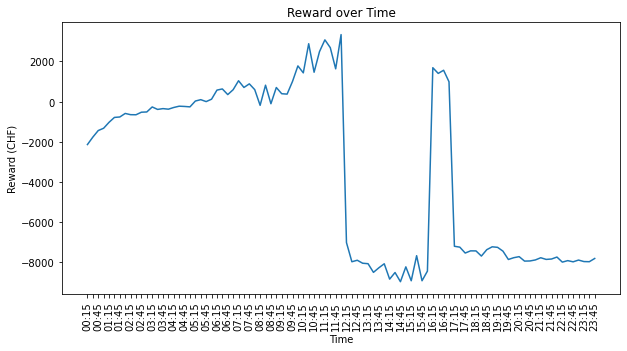

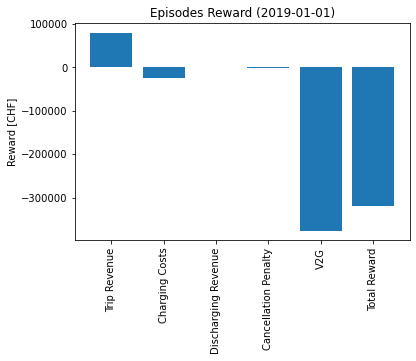

1.7028677031349915e-05

single positional indexer is out-of-bounds
reservation no
24521792.0
24521792.0
station_no
4524.0
vehicle id
115325

single positional indexer is out-of-bounds
reservation no
24521800.0
24521800.0
station_no
1603.0
vehicle id
116903

single positional indexer is out-of-bounds
reservation no
24521794.0
24521794.0
station_no
4701.0
vehicle id
119435

single positional indexer is out-of-bounds
reservation no
24521792.0
24521792.0
station_no
4524.0
vehicle id
115325

single positional indexer is out-of-bounds
reservation no
24521800.0
24521800.0
station_no
1603.0
vehicle id
116903

single positional indexer is out-of-bounds
reservation no
24521794.0
24521794.0
station_no
4701.0
vehicle id
119435
-------- State at time 2019-01-02 00:15:00 --------
Reward in this step: -2064.6366640520364  time:  1
0.0003830102194510854
-------- State at time 2019-01-02 00:30:00 --------
Reward in this step: -1874.8070393880716  time:  2
0.0003830102194510854

single positional indexe

-------- State at time 2019-01-02 05:45:00 --------
Reward in this step: 0.0  time:  23
0.0

single positional indexer is out-of-bounds
reservation no
24521864.0
24521864.0
station_no
4254.0
vehicle id
113527

single positional indexer is out-of-bounds
reservation no
24521863.0
24521863.0
station_no
4807.0
vehicle id
116059

single positional indexer is out-of-bounds
reservation no
24521865.0
24521865.0
station_no
2876.0
vehicle id
116136

single positional indexer is out-of-bounds
reservation no
24457847.0
24457847.0
station_no
4604.0
vehicle id
116274

single positional indexer is out-of-bounds
reservation no
24513232.0
24513232.0
station_no
1084.0
vehicle id
116772

single positional indexer is out-of-bounds
reservation no
24521828.0
24521828.0
station_no
3953.0
vehicle id
119449

single positional indexer is out-of-bounds
reservation no
24521864.0
24521864.0
station_no
4254.0
vehicle id
113527

single positional indexer is out-of-bounds
reservation no
24521863.0
24521863.0
station_


single positional indexer is out-of-bounds
reservation no
24475934.0
24475934.0
station_no
2856.0
vehicle id
113531

single positional indexer is out-of-bounds
reservation no
24446281.0
24446281.0
station_no
3104.0
vehicle id
113546

single positional indexer is out-of-bounds
reservation no
24446143.0
24446143.0
station_no
3122.0
vehicle id
114020

single positional indexer is out-of-bounds
reservation no
24499388.0
24499388.0
station_no
1913.0
vehicle id
114363

single positional indexer is out-of-bounds
reservation no
24510263.0
24510263.0
station_no
1740.0
vehicle id
114530

single positional indexer is out-of-bounds
reservation no
24474513.0
24474513.0
station_no
1204.0
vehicle id
114743

single positional indexer is out-of-bounds
reservation no
24474091.0
24474091.0
station_no
1203.0
vehicle id
114752

single positional indexer is out-of-bounds
reservation no
24519360.0
24519360.0
station_no
2842.0
vehicle id
114903

single positional indexer is out-of-bounds
reservation no
24420

reservation no
24521497.0
24521497.0
station_no
4381.0
vehicle id
119436

single positional indexer is out-of-bounds
reservation no
24397167.0
24397167.0
station_no
2528.0
vehicle id
119676
-------- State at time 2019-01-02 08:15:00 --------
Reward in this step: -8958.515981948374  time:  33
0.0

single positional indexer is out-of-bounds
reservation no
24521112.0
24521112.0
station_no
1271.0
vehicle id
114009

single positional indexer is out-of-bounds
reservation no
24521984.0
24521984.0
station_no
4438.0
vehicle id
114151

single positional indexer is out-of-bounds
reservation no
24520462.0
24520462.0
station_no
3026.0
vehicle id
114241

single positional indexer is out-of-bounds
reservation no
24518926.0
24518926.0
station_no
2025.0
vehicle id
114287

single positional indexer is out-of-bounds
reservation no
24521935.0
24521935.0
station_no
4311.0
vehicle id
114351

single positional indexer is out-of-bounds
reservation no
24521936.0
24521936.0
station_no
3255.0
vehicle id
114386




single positional indexer is out-of-bounds
reservation no
24521880.0
24521880.0
station_no
2886.0
vehicle id
116776

single positional indexer is out-of-bounds
reservation no
24521344.0
24521344.0
station_no
1800.0
vehicle id
116923

single positional indexer is out-of-bounds
reservation no
24250920.0
24250920.0
station_no
2854.0
vehicle id
118199

single positional indexer is out-of-bounds
reservation no
24228964.0
24228964.0
station_no
1622.0
vehicle id
119460

single positional indexer is out-of-bounds
reservation no
24521927.0
24521927.0
station_no
3141.0
vehicle id
119495

single positional indexer is out-of-bounds
reservation no
24522000.0
24522000.0
station_no
4351.0
vehicle id
113557

single positional indexer is out-of-bounds
reservation no
24520108.0
24520108.0
station_no
1984.0
vehicle id
114374

single positional indexer is out-of-bounds
reservation no
24521753.0
24521753.0
station_no
1925.0
vehicle id
114470

single positional indexer is out-of-bounds
reservation no
24516


single positional indexer is out-of-bounds
reservation no
24516485.0
24516485.0
station_no
3299.0
vehicle id
113136

single positional indexer is out-of-bounds
reservation no
24521193.0
24521193.0
station_no
1268.0
vehicle id
113269

single positional indexer is out-of-bounds
reservation no
24521913.0
24521913.0
station_no
1293.0
vehicle id
113533

single positional indexer is out-of-bounds
reservation no
24521842.0
24521842.0
station_no
3782.0
vehicle id
113802

single positional indexer is out-of-bounds
reservation no
24519446.0
24519446.0
station_no
2668.0
vehicle id
113904

single positional indexer is out-of-bounds
reservation no
24516275.0
24516275.0
station_no
4301.0
vehicle id
113926

single positional indexer is out-of-bounds
reservation no
24517492.0
24517492.0
station_no
1941.0
vehicle id
113932

single positional indexer is out-of-bounds
reservation no
24521088.0
24521088.0
station_no
2985.0
vehicle id
114128

single positional indexer is out-of-bounds
reservation no
24301


single positional indexer is out-of-bounds
reservation no
24520625.0
24520625.0
station_no
4417.0
vehicle id
117007

single positional indexer is out-of-bounds
reservation no
24521996.0
24521996.0
station_no
4280.0
vehicle id
117014

single positional indexer is out-of-bounds
reservation no
24519784.0
24519784.0
station_no
1843.0
vehicle id
113017

single positional indexer is out-of-bounds
reservation no
24520987.0
24520987.0
station_no
1081.0
vehicle id
113799

single positional indexer is out-of-bounds
reservation no
24521316.0
24521316.0
station_no
1966.0
vehicle id
114044

single positional indexer is out-of-bounds
reservation no
24520292.0
24520292.0
station_no
1563.0
vehicle id
114087

single positional indexer is out-of-bounds
reservation no
24518939.0
24518939.0
station_no
2877.0
vehicle id
114134

single positional indexer is out-of-bounds
reservation no
24520233.0
24520233.0
station_no
3990.0
vehicle id
114174

single positional indexer is out-of-bounds
reservation no
24522


single positional indexer is out-of-bounds
reservation no
24519605.0
24519605.0
station_no
1112.0
vehicle id
116543

single positional indexer is out-of-bounds
reservation no
24521132.0
24521132.0
station_no
2886.0
vehicle id
116647

single positional indexer is out-of-bounds
reservation no
24521375.0
24521375.0
station_no
2558.0
vehicle id
116665

single positional indexer is out-of-bounds
reservation no
24513789.0
24513789.0
station_no
2896.0
vehicle id
116689

single positional indexer is out-of-bounds
reservation no
24516169.0
24516169.0
station_no
1512.0
vehicle id
116740

single positional indexer is out-of-bounds
reservation no
24499271.0
24499271.0
station_no
1209.0
vehicle id
116781

single positional indexer is out-of-bounds
reservation no
24519893.0
24519893.0
station_no
1643.0
vehicle id
116934

single positional indexer is out-of-bounds
reservation no
24522087.0
24522087.0
station_no
2780.0
vehicle id
116987

single positional indexer is out-of-bounds
reservation no
24517


single positional indexer is out-of-bounds
reservation no
24520028.0
24520028.0
station_no
2155.0
vehicle id
116871

single positional indexer is out-of-bounds
reservation no
24521592.0
24521592.0
station_no
4572.0
vehicle id
116901

single positional indexer is out-of-bounds
reservation no
24507305.0
24507305.0
station_no
3953.0
vehicle id
116993

single positional indexer is out-of-bounds
reservation no
24521211.0
24521211.0
station_no
1850.0
vehicle id
116997

single positional indexer is out-of-bounds
reservation no
24522129.0
24522129.0
station_no
3206.0
vehicle id
119485

single positional indexer is out-of-bounds
reservation no
24470429.0
24470429.0
station_no
4363.0
vehicle id
119563

single positional indexer is out-of-bounds
reservation no
24521030.0
24521030.0
station_no
1735.0
vehicle id
119672

single positional indexer is out-of-bounds
reservation no
24350930.0
24350930.0
station_no
4268.0
vehicle id
113266

single positional indexer is out-of-bounds
reservation no
24522

single positional indexer is out-of-bounds
reservation no
24520025.0
24520025.0
station_no
1688.0
vehicle id
115469

single positional indexer is out-of-bounds
reservation no
24517164.0
24517164.0
station_no
4015.0
vehicle id
115583

single positional indexer is out-of-bounds
reservation no
24521680.0
24521680.0
station_no
2718.0
vehicle id
115593

single positional indexer is out-of-bounds
reservation no
24522255.0
24522255.0
station_no
2083.0
vehicle id
115628

single positional indexer is out-of-bounds
reservation no
24516694.0
24516694.0
station_no
1595.0
vehicle id
115640

single positional indexer is out-of-bounds
reservation no
24521103.0
24521103.0
station_no
1019.0
vehicle id
115716

single positional indexer is out-of-bounds
reservation no
24517107.0
24517107.0
station_no
2877.0
vehicle id
115739

single positional indexer is out-of-bounds
reservation no
24520598.0
24520598.0
station_no
3230.0
vehicle id
115796

single positional indexer is out-of-bounds
reservation no
245221

vehicle id
114934

single positional indexer is out-of-bounds
reservation no
24520185.0
24520185.0
station_no
1652.0
vehicle id
114944

single positional indexer is out-of-bounds
reservation no
24521948.0
24521948.0
station_no
3735.0
vehicle id
115014

single positional indexer is out-of-bounds
reservation no
24522125.0
24522125.0
station_no
3737.0
vehicle id
115027

single positional indexer is out-of-bounds
reservation no
24520531.0
24520531.0
station_no
4385.0
vehicle id
115187

single positional indexer is out-of-bounds
reservation no
24522264.0
24522264.0
station_no
2823.0
vehicle id
115198

single positional indexer is out-of-bounds
reservation no
24518807.0
24518807.0
station_no
3735.0
vehicle id
115208

single positional indexer is out-of-bounds
reservation no
24521606.0
24521606.0
station_no
4517.0
vehicle id
115218

single positional indexer is out-of-bounds
reservation no
24521203.0
24521203.0
station_no
5227.0
vehicle id
115225

single positional indexer is out-of-bounds
re


single positional indexer is out-of-bounds
reservation no
24522157.0
24522157.0
station_no
1156.0
vehicle id
115009

single positional indexer is out-of-bounds
reservation no
24511763.0
24511763.0
station_no
1103.0
vehicle id
115046

single positional indexer is out-of-bounds
reservation no
24522258.0
24522258.0
station_no
4069.0
vehicle id
115157

single positional indexer is out-of-bounds
reservation no
24507277.0
24507277.0
station_no
4016.0
vehicle id
115178

single positional indexer is out-of-bounds
reservation no
24522227.0
24522227.0
station_no
4535.0
vehicle id
115180

single positional indexer is out-of-bounds
reservation no
24521155.0
24521155.0
station_no
1576.0
vehicle id
115186

single positional indexer is out-of-bounds
reservation no
24521674.0
24521674.0
station_no
4101.0
vehicle id
115221

single positional indexer is out-of-bounds
reservation no
24522239.0
24522239.0
station_no
2928.0
vehicle id
115271

single positional indexer is out-of-bounds
reservation no
24521


single positional indexer is out-of-bounds
reservation no
24519585.0
24519585.0
station_no
2948.0
vehicle id
113239

single positional indexer is out-of-bounds
reservation no
24521255.0
24521255.0
station_no
1521.0
vehicle id
113371

single positional indexer is out-of-bounds
reservation no
24522321.0
24522321.0
station_no
2324.0
vehicle id
113470

single positional indexer is out-of-bounds
reservation no
24521047.0
24521047.0
station_no
1887.0
vehicle id
113504

single positional indexer is out-of-bounds
reservation no
24516463.0
24516463.0
station_no
1109.0
vehicle id
113574

single positional indexer is out-of-bounds
reservation no
24521958.0
24521958.0
station_no
1529.0
vehicle id
113741

single positional indexer is out-of-bounds
reservation no
24521296.0
24521296.0
station_no
2959.0
vehicle id
113997

single positional indexer is out-of-bounds
reservation no
24522142.0
24522142.0
station_no
4509.0
vehicle id
114003

single positional indexer is out-of-bounds
reservation no
24514


single positional indexer is out-of-bounds
reservation no
24518694.0
24518694.0
station_no
4771.0
vehicle id
115255

single positional indexer is out-of-bounds
reservation no
24522100.0
24522100.0
station_no
1939.0
vehicle id
115344

single positional indexer is out-of-bounds
reservation no
24522550.0
24522550.0
station_no
1527.0
vehicle id
115547

single positional indexer is out-of-bounds
reservation no
24514556.0
24514556.0
station_no
4355.0
vehicle id
115689

single positional indexer is out-of-bounds
reservation no
24522176.0
24522176.0
station_no
2528.0
vehicle id
115744

single positional indexer is out-of-bounds
reservation no
24522244.0
24522244.0
station_no
1038.0
vehicle id
115758

single positional indexer is out-of-bounds
reservation no
24522388.0
24522388.0
station_no
3729.0
vehicle id
115782

single positional indexer is out-of-bounds
reservation no
24522362.0
24522362.0
station_no
4566.0
vehicle id
115821

single positional indexer is out-of-bounds
reservation no
24499


single positional indexer is out-of-bounds
reservation no
24522633.0
24522633.0
station_no
1557.0
vehicle id
115550

single positional indexer is out-of-bounds
reservation no
24522314.0
24522314.0
station_no
3148.0
vehicle id
115605

single positional indexer is out-of-bounds
reservation no
24521147.0
24521147.0
station_no
1622.0
vehicle id
115634

single positional indexer is out-of-bounds
reservation no
24519640.0
24519640.0
station_no
1086.0
vehicle id
115639

single positional indexer is out-of-bounds
reservation no
24522303.0
24522303.0
station_no
4260.0
vehicle id
115746

single positional indexer is out-of-bounds
reservation no
24522225.0
24522225.0
station_no
4634.0
vehicle id
115769

single positional indexer is out-of-bounds
reservation no
24522226.0
24522226.0
station_no
3808.0
vehicle id
115783

single positional indexer is out-of-bounds
reservation no
24522343.0
24522343.0
station_no
3216.0
vehicle id
115823

single positional indexer is out-of-bounds
reservation no
24522


single positional indexer is out-of-bounds
reservation no
24522343.0
24522343.0
station_no
3216.0
vehicle id
115823

single positional indexer is out-of-bounds
reservation no
24522617.0
24522617.0
station_no
1592.0
vehicle id
115958

single positional indexer is out-of-bounds
reservation no
24520510.0
24520510.0
station_no
1625.0
vehicle id
115963

single positional indexer is out-of-bounds
reservation no
24519904.0
24519904.0
station_no
1253.0
vehicle id
115965

single positional indexer is out-of-bounds
reservation no
24522270.0
24522270.0
station_no
4423.0
vehicle id
115990

single positional indexer is out-of-bounds
reservation no
24522386.0
24522386.0
station_no
4738.0
vehicle id
115993

single positional indexer is out-of-bounds
reservation no
24522234.0
24522234.0
station_no
2376.0
vehicle id
116017

single positional indexer is out-of-bounds
reservation no
24522206.0
24522206.0
station_no
4744.0
vehicle id
116109

single positional indexer is out-of-bounds
reservation no
24499

single positional indexer is out-of-bounds
reservation no
24522745.0
24522745.0
station_no
2593.0
vehicle id
115343

single positional indexer is out-of-bounds
reservation no
24522410.0
24522410.0
station_no
1122.0
vehicle id
115428

single positional indexer is out-of-bounds
reservation no
24522171.0
24522171.0
station_no
1177.0
vehicle id
115439

single positional indexer is out-of-bounds
reservation no
24522390.0
24522390.0
station_no
1511.0
vehicle id
115447

single positional indexer is out-of-bounds
reservation no
24521164.0
24521164.0
station_no
2871.0
vehicle id
115597

single positional indexer is out-of-bounds
reservation no
24520165.0
24520165.0
station_no
2888.0
vehicle id
115600

single positional indexer is out-of-bounds
reservation no
24521655.0
24521655.0
station_no
1058.0
vehicle id
115974

single positional indexer is out-of-bounds
reservation no
24522610.0
24522610.0
station_no
5000.0
vehicle id
116022

single positional indexer is out-of-bounds
reservation no
245215


single positional indexer is out-of-bounds
reservation no
24522667.0
24522667.0
station_no
3143.0
vehicle id
114836

single positional indexer is out-of-bounds
reservation no
24522689.0
24522689.0
station_no
3737.0
vehicle id
115112

single positional indexer is out-of-bounds
reservation no
24522533.0
24522533.0
station_no
3296.0
vehicle id
115128

single positional indexer is out-of-bounds
reservation no
24522424.0
24522424.0
station_no
1843.0
vehicle id
115170

single positional indexer is out-of-bounds
reservation no
24520620.0
24520620.0
station_no
2882.0
vehicle id
115235

single positional indexer is out-of-bounds
reservation no
24521045.0
24521045.0
station_no
4601.0
vehicle id
115299

single positional indexer is out-of-bounds
reservation no
24519436.0
24519436.0
station_no
3295.0
vehicle id
115346

single positional indexer is out-of-bounds
reservation no
24510558.0
24510558.0
station_no
3142.0
vehicle id
115413

single positional indexer is out-of-bounds
reservation no
24521

station_no
3085.0
vehicle id
116777

single positional indexer is out-of-bounds
reservation no
24520595.0
24520595.0
station_no
4667.0
vehicle id
116832

single positional indexer is out-of-bounds
reservation no
24522287.0
24522287.0
station_no
2661.0
vehicle id
116982

single positional indexer is out-of-bounds
reservation no
24519694.0
24519694.0
station_no
1095.0
vehicle id
119464

single positional indexer is out-of-bounds
reservation no
24517192.0
24517192.0
station_no
3253.0
vehicle id
119491

single positional indexer is out-of-bounds
reservation no
24522731.0
24522731.0
station_no
1204.0
vehicle id
119571

single positional indexer is out-of-bounds
reservation no
24512166.0
24512166.0
station_no
3115.0
vehicle id
113362

single positional indexer is out-of-bounds
reservation no
24522901.0
24522901.0
station_no
3108.0
vehicle id
113573

single positional indexer is out-of-bounds
reservation no
24522666.0
24522666.0
station_no
3872.0
vehicle id
113664

single positional indexer i


single positional indexer is out-of-bounds
reservation no
24522242.0
24522242.0
station_no
4110.0
vehicle id
116957

single positional indexer is out-of-bounds
reservation no
24522698.0
24522698.0
station_no
4491.0
vehicle id
116985

single positional indexer is out-of-bounds
reservation no
24521295.0
24521295.0
station_no
1975.0
vehicle id
119489

single positional indexer is out-of-bounds
reservation no
24520383.0
24520383.0
station_no
3972.0
vehicle id
119537

single positional indexer is out-of-bounds
reservation no
24518772.0
24518772.0
station_no
1767.0
vehicle id
119558

single positional indexer is out-of-bounds
reservation no
24522559.0
24522559.0
station_no
4819.0
vehicle id
119574

single positional indexer is out-of-bounds
reservation no
24521501.0
24521501.0
station_no
3737.0
vehicle id
119667

single positional indexer is out-of-bounds
reservation no
24522725.0
24522725.0
station_no
2702.0
vehicle id
113185

single positional indexer is out-of-bounds
reservation no
24521


single positional indexer is out-of-bounds
reservation no
24522726.0
24522726.0
station_no
1740.0
vehicle id
114711

single positional indexer is out-of-bounds
reservation no
24522397.0
24522397.0
station_no
3284.0
vehicle id
115262

single positional indexer is out-of-bounds
reservation no
24522913.0
24522913.0
station_no
2734.0
vehicle id
115422

single positional indexer is out-of-bounds
reservation no
24522351.0
24522351.0
station_no
3933.0
vehicle id
115430

single positional indexer is out-of-bounds
reservation no
24522829.0
24522829.0
station_no
1066.0
vehicle id
115535

single positional indexer is out-of-bounds
reservation no
24521710.0
24521710.0
station_no
1998.0
vehicle id
115558

single positional indexer is out-of-bounds
reservation no
24518936.0
24518936.0
station_no
4289.0
vehicle id
115594

single positional indexer is out-of-bounds
reservation no
24522938.0
24522938.0
station_no
2526.0
vehicle id
115596

single positional indexer is out-of-bounds
reservation no
24521

-------- State at time 2019-01-02 12:30:00 --------
Reward in this step: 0.0  time:  50
0.0

single positional indexer is out-of-bounds
reservation no
24522757.0
24522757.0
station_no
1164.0
vehicle id
113349

single positional indexer is out-of-bounds
reservation no
24521122.0
24521122.0
station_no
2907.0
vehicle id
113834

single positional indexer is out-of-bounds
reservation no
24522739.0
24522739.0
station_no
3736.0
vehicle id
114153

single positional indexer is out-of-bounds
reservation no
24512159.0
24512159.0
station_no
1204.0
vehicle id
114155

single positional indexer is out-of-bounds
reservation no
24522764.0
24522764.0
station_no
1734.0
vehicle id
114206

single positional indexer is out-of-bounds
reservation no
24522228.0
24522228.0
station_no
1618.0
vehicle id
114207

single positional indexer is out-of-bounds
reservation no
24514609.0
24514609.0
station_no
1081.0
vehicle id
114238

single positional indexer is out-of-bounds
reservation no
24523075.0
24523075.0
station_


single positional indexer is out-of-bounds
reservation no
24523147.0
24523147.0
station_no
2130.0
vehicle id
115174

single positional indexer is out-of-bounds
reservation no
24522215.0
24522215.0
station_no
4692.0
vehicle id
115202

single positional indexer is out-of-bounds
reservation no
24523071.0
24523071.0
station_no
3798.0
vehicle id
115246

single positional indexer is out-of-bounds
reservation no
24522602.0
24522602.0
station_no
3216.0
vehicle id
115273

single positional indexer is out-of-bounds
reservation no
24522968.0
24522968.0
station_no
2794.0
vehicle id
115360

single positional indexer is out-of-bounds
reservation no
24523250.0
24523250.0
station_no
1122.0
vehicle id
115375

single positional indexer is out-of-bounds
reservation no
24523019.0
24523019.0
station_no
2840.0
vehicle id
115420

single positional indexer is out-of-bounds
reservation no
24518884.0
24518884.0
station_no
4605.0
vehicle id
115426

single positional indexer is out-of-bounds
reservation no
24523

24523177.0
station_no
1663.0
vehicle id
116070

single positional indexer is out-of-bounds
reservation no
24522020.0
24522020.0
station_no
3235.0
vehicle id
116105

single positional indexer is out-of-bounds
reservation no
24520388.0
24520388.0
station_no
3240.0
vehicle id
116154

single positional indexer is out-of-bounds
reservation no
24520243.0
24520243.0
station_no
1819.0
vehicle id
116163

single positional indexer is out-of-bounds
reservation no
24523254.0
24523254.0
station_no
3808.0
vehicle id
116194

single positional indexer is out-of-bounds
reservation no
24523066.0
24523066.0
station_no
3872.0
vehicle id
116302

single positional indexer is out-of-bounds
reservation no
24520737.0
24520737.0
station_no
4145.0
vehicle id
116312

single positional indexer is out-of-bounds
reservation no
24500910.0
24500910.0
station_no
2945.0
vehicle id
116462

single positional indexer is out-of-bounds
reservation no
24520274.0
24520274.0
station_no
2153.0
vehicle id
116495

single positiona


single positional indexer is out-of-bounds
reservation no
24523025.0
24523025.0
station_no
4633.0
vehicle id
115409

single positional indexer is out-of-bounds
reservation no
24520154.0
24520154.0
station_no
1540.0
vehicle id
115418

single positional indexer is out-of-bounds
reservation no
24522408.0
24522408.0
station_no
2051.0
vehicle id
115484

single positional indexer is out-of-bounds
reservation no
24523221.0
24523221.0
station_no
1596.0
vehicle id
115584

single positional indexer is out-of-bounds
reservation no
24522363.0
24522363.0
station_no
24513499.0
vehicle id
115661

single positional indexer is out-of-bounds
reservation no
24520322.0
24520322.0
station_no
2323.0
vehicle id
115691

single positional indexer is out-of-bounds
reservation no
24522273.0
24522273.0
station_no
2333.0
vehicle id
115772

single positional indexer is out-of-bounds
reservation no
24521055.0
24521055.0
station_no
3921.0
vehicle id
115815

single positional indexer is out-of-bounds
reservation no
2


single positional indexer is out-of-bounds
reservation no
24522956.0
24522956.0
station_no
1084.0
vehicle id
114436

single positional indexer is out-of-bounds
reservation no
24523376.0
24523376.0
station_no
1151.0
vehicle id
114861

single positional indexer is out-of-bounds
reservation no
24523420.0
24523420.0
station_no
2008.0
vehicle id
114877

single positional indexer is out-of-bounds
reservation no
24513709.0
24513709.0
station_no
1226.0
vehicle id
114894

single positional indexer is out-of-bounds
reservation no
24523061.0
24523061.0
station_no
1149.0
vehicle id
114895

single positional indexer is out-of-bounds
reservation no
24502362.0
24502362.0
station_no
2422.0
vehicle id
114927

single positional indexer is out-of-bounds
reservation no
24498993.0
24498993.0
station_no
2170.0
vehicle id
114942

single positional indexer is out-of-bounds
reservation no
24521502.0
24521502.0
station_no
4298.0
vehicle id
115029

single positional indexer is out-of-bounds
reservation no
24518

single positional indexer is out-of-bounds
reservation no
24523495.0
24523495.0
station_no
4759.0
vehicle id
114116

single positional indexer is out-of-bounds
reservation no
24522208.0
24522208.0
station_no
4429.0
vehicle id
114222

single positional indexer is out-of-bounds
reservation no
24522943.0
24522943.0
station_no
4437.0
vehicle id
114254

single positional indexer is out-of-bounds
reservation no
24523518.0
24523518.0
station_no
4419.0
vehicle id
114288

single positional indexer is out-of-bounds
reservation no
24464785.0
24464785.0
station_no
2604.0
vehicle id
114358

single positional indexer is out-of-bounds
reservation no
24521608.0
24521608.0
station_no
2548.0
vehicle id
114509

single positional indexer is out-of-bounds
reservation no
24523444.0
24523444.0
station_no
2953.0
vehicle id
114514

single positional indexer is out-of-bounds
reservation no
24523458.0
24523458.0
station_no
3143.0
vehicle id
114538

single positional indexer is out-of-bounds
reservation no
245231

single positional indexer is out-of-bounds
reservation no
24485738.0
24485738.0
station_no
2877.0
vehicle id
116208

single positional indexer is out-of-bounds
reservation no
24522871.0
24522871.0
station_no
1725.0
vehicle id
116263

single positional indexer is out-of-bounds
reservation no
24523423.0
24523423.0
station_no
1244.0
vehicle id
116287

single positional indexer is out-of-bounds
reservation no
24522549.0
24522549.0
station_no
1697.0
vehicle id
116290

single positional indexer is out-of-bounds
reservation no
24523417.0
24523417.0
station_no
1198.0
vehicle id
116303

single positional indexer is out-of-bounds
reservation no
24523374.0
24523374.0
station_no
1261.0
vehicle id
116356

single positional indexer is out-of-bounds
reservation no
24520522.0
24520522.0
station_no
1767.0
vehicle id
116364

single positional indexer is out-of-bounds
reservation no
24521707.0
24521707.0
station_no
4552.0
vehicle id
116491

single positional indexer is out-of-bounds
reservation no
245232


single positional indexer is out-of-bounds
reservation no
24523365.0
24523365.0
station_no
3288.0
vehicle id
115223

single positional indexer is out-of-bounds
reservation no
24490597.0
24490597.0
station_no
1220.0
vehicle id
115244

single positional indexer is out-of-bounds
reservation no
24514472.0
24514472.0
station_no
3725.0
vehicle id
115250

single positional indexer is out-of-bounds
reservation no
24523379.0
24523379.0
station_no
1212.0
vehicle id
115257

single positional indexer is out-of-bounds
reservation no
24523262.0
24523262.0
station_no
4590.0
vehicle id
115309

single positional indexer is out-of-bounds
reservation no
24523353.0
24523353.0
station_no
2593.0
vehicle id
115343

single positional indexer is out-of-bounds
reservation no
24427150.0
24427150.0
station_no
2500.0
vehicle id
115506

single positional indexer is out-of-bounds
reservation no
24520736.0
24520736.0
station_no
4483.0
vehicle id
115534

single positional indexer is out-of-bounds
reservation no
24520

114315

single positional indexer is out-of-bounds
reservation no
24523481.0
24523481.0
station_no
2329.0
vehicle id
114388

single positional indexer is out-of-bounds
reservation no
24523325.0
24523325.0
station_no
4519.0
vehicle id
114416

single positional indexer is out-of-bounds
reservation no
24523238.0
24523238.0
station_no
4524.0
vehicle id
114433

single positional indexer is out-of-bounds
reservation no
24523479.0
24523479.0
station_no
4397.0
vehicle id
114480

single positional indexer is out-of-bounds
reservation no
24523501.0
24523501.0
station_no
2842.0
vehicle id
114632

single positional indexer is out-of-bounds
reservation no
24523688.0
24523688.0
station_no
2761.0
vehicle id
114690

single positional indexer is out-of-bounds
reservation no
24523140.0
24523140.0
station_no
1535.0
vehicle id
114772

single positional indexer is out-of-bounds
reservation no
24523624.0
24523624.0
station_no
4759.0
vehicle id
114792

single positional indexer is out-of-bounds
reservation n


single positional indexer is out-of-bounds
reservation no
24523101.0
24523101.0
station_no
3245.0
vehicle id
115614

single positional indexer is out-of-bounds
reservation no
24521814.0
24521814.0
station_no
4354.0
vehicle id
115721

single positional indexer is out-of-bounds
reservation no
24523757.0
24523757.0
station_no
1963.0
vehicle id
116041

single positional indexer is out-of-bounds
reservation no
24520706.0
24520706.0
station_no
4722.0
vehicle id
116080

single positional indexer is out-of-bounds
reservation no
24523554.0
24523554.0
station_no
1261.0
vehicle id
116205

single positional indexer is out-of-bounds
reservation no
24522618.0
24522618.0
station_no
5000.0
vehicle id
116211

single positional indexer is out-of-bounds
reservation no
24522903.0
24522903.0
station_no
1036.0
vehicle id
116456

single positional indexer is out-of-bounds
reservation no
24519887.0
24519887.0
station_no
2333.0
vehicle id
116492

single positional indexer is out-of-bounds
reservation no
24517


single positional indexer is out-of-bounds
reservation no
24523477.0
24523477.0
station_no
2350.0
vehicle id
115519

single positional indexer is out-of-bounds
reservation no
24523826.0
24523826.0
station_no
1296.0
vehicle id
115568

single positional indexer is out-of-bounds
reservation no
24517505.0
24517505.0
station_no
4654.0
vehicle id
115656

single positional indexer is out-of-bounds
reservation no
24523813.0
24523813.0
station_no
2236.0
vehicle id
115726

single positional indexer is out-of-bounds
reservation no
24505044.0
24505044.0
station_no
24522176.0
vehicle id
115744

single positional indexer is out-of-bounds
reservation no
24520971.0
24520971.0
station_no
2001.0
vehicle id
115773

single positional indexer is out-of-bounds
reservation no
24521653.0
24521653.0
station_no
2844.0
vehicle id
115999

single positional indexer is out-of-bounds
reservation no
24523136.0
24523136.0
station_no
1939.0
vehicle id
116039

single positional indexer is out-of-bounds
reservation no
2


single positional indexer is out-of-bounds
reservation no
24523698.0
24523698.0
station_no
4586.0
vehicle id
114075

single positional indexer is out-of-bounds
reservation no
24523854.0
24523854.0
station_no
1107.0
vehicle id
114150

single positional indexer is out-of-bounds
reservation no
24523902.0
24523902.0
station_no
1830.0
vehicle id
114173

single positional indexer is out-of-bounds
reservation no
24521383.0
24521383.0
station_no
24522836.0
vehicle id
114176

single positional indexer is out-of-bounds
reservation no
24523548.0
24523548.0
station_no
3733.0
vehicle id
114322

single positional indexer is out-of-bounds
reservation no
24522960.0
24522960.0
station_no
4064.0
vehicle id
114359

single positional indexer is out-of-bounds
reservation no
24520819.0
24520819.0
station_no
4674.0
vehicle id
114371

single positional indexer is out-of-bounds
reservation no
24522942.0
24522942.0
station_no
1609.0
vehicle id
114377

single positional indexer is out-of-bounds
reservation no
2

115607

single positional indexer is out-of-bounds
reservation no
24523958.0
24523958.0
station_no
4817.0
vehicle id
115959

single positional indexer is out-of-bounds
reservation no
24523762.0
24523762.0
station_no
4337.0
vehicle id
116040

single positional indexer is out-of-bounds
reservation no
24522608.0
24522608.0
station_no
1543.0
vehicle id
116282

single positional indexer is out-of-bounds
reservation no
24522712.0
24522712.0
station_no
1996.0
vehicle id
116433

single positional indexer is out-of-bounds
reservation no
24521142.0
24521142.0
station_no
1091.0
vehicle id
116540

single positional indexer is out-of-bounds
reservation no
24523618.0
24523618.0
station_no
4480.0
vehicle id
116755

single positional indexer is out-of-bounds
reservation no
24523937.0
24523937.0
station_no
2602.0
vehicle id
116779

single positional indexer is out-of-bounds
reservation no
24523874.0
24523874.0
station_no
3978.0
vehicle id
116945

single positional indexer is out-of-bounds
reservation n

single positional indexer is out-of-bounds
reservation no
24523979.0
24523979.0
station_no
4634.0
vehicle id
115359

single positional indexer is out-of-bounds
reservation no
24522317.0
24522317.0
station_no
4420.0
vehicle id
115404

single positional indexer is out-of-bounds
reservation no
24519046.0
24519046.0
station_no
3291.0
vehicle id
115502

single positional indexer is out-of-bounds
reservation no
24523405.0
24523405.0
station_no
4512.0
vehicle id
115541

single positional indexer is out-of-bounds
reservation no
24517642.0
24517642.0
station_no
3278.0
vehicle id
115724

single positional indexer is out-of-bounds
reservation no
24523855.0
24523855.0
station_no
4566.0
vehicle id
115821

single positional indexer is out-of-bounds
reservation no
24518995.0
24518995.0
station_no
2842.0
vehicle id
115961

single positional indexer is out-of-bounds
reservation no
24523983.0
24523983.0
station_no
1864.0
vehicle id
116052

single positional indexer is out-of-bounds
reservation no
245239


single positional indexer is out-of-bounds
reservation no
24524064.0
24524064.0
station_no
1979.0
vehicle id
114112

single positional indexer is out-of-bounds
reservation no
24524115.0
24524115.0
station_no
1290.0
vehicle id
114239

single positional indexer is out-of-bounds
reservation no
24524073.0
24524073.0
station_no
4662.0
vehicle id
114372

single positional indexer is out-of-bounds
reservation no
24523472.0
24523472.0
station_no
3699.0
vehicle id
114449

single positional indexer is out-of-bounds
reservation no
24524002.0
24524002.0
station_no
2944.0
vehicle id
114475

single positional indexer is out-of-bounds
reservation no
24522742.0
24522742.0
station_no
1647.0
vehicle id
114481

single positional indexer is out-of-bounds
reservation no
24522721.0
24522721.0
station_no
4212.0
vehicle id
114626

single positional indexer is out-of-bounds
reservation no
24522929.0
24522929.0
station_no
1625.0
vehicle id
114678

single positional indexer is out-of-bounds
reservation no
24523


single positional indexer is out-of-bounds
reservation no
24518465.0
24518465.0
station_no
1724.0
vehicle id
115203

single positional indexer is out-of-bounds
reservation no
24445965.0
24445965.0
station_no
2850.0
vehicle id
115217

single positional indexer is out-of-bounds
reservation no
24479035.0
24479035.0
station_no
1204.0
vehicle id
115268

single positional indexer is out-of-bounds
reservation no
24523015.0
24523015.0
station_no
2928.0
vehicle id
115271

single positional indexer is out-of-bounds
reservation no
24515120.0
24515120.0
station_no
2128.0
vehicle id
115276

single positional indexer is out-of-bounds
reservation no
24524192.0
24524192.0
station_no
4305.0
vehicle id
115457

single positional indexer is out-of-bounds
reservation no
24522573.0
24522573.0
station_no
2407.0
vehicle id
115567

single positional indexer is out-of-bounds
reservation no
24516142.0
24516142.0
station_no
4704.0
vehicle id
115632

single positional indexer is out-of-bounds
reservation no
24501


single positional indexer is out-of-bounds
reservation no
24519576.0
24519576.0
station_no
1633.0
vehicle id
115730

single positional indexer is out-of-bounds
reservation no
24522367.0
24522367.0
station_no
1720.0
vehicle id
115763

single positional indexer is out-of-bounds
reservation no
24524287.0
24524287.0
station_no
3152.0
vehicle id
115998

single positional indexer is out-of-bounds
reservation no
24524246.0
24524246.0
station_no
3923.0
vehicle id
116009

single positional indexer is out-of-bounds
reservation no
24524040.0
24524040.0
station_no
1509.0
vehicle id
116102

single positional indexer is out-of-bounds
reservation no
24519124.0
24519124.0
station_no
3130.0
vehicle id
116149

single positional indexer is out-of-bounds
reservation no
24510614.0
24510614.0
station_no
2346.0
vehicle id
116196

single positional indexer is out-of-bounds
reservation no
24515964.0
24515964.0
station_no
4725.0
vehicle id
116257

single positional indexer is out-of-bounds
reservation no
24520


single positional indexer is out-of-bounds
reservation no
24524169.0
24524169.0
station_no
4617.0
vehicle id
115251

single positional indexer is out-of-bounds
reservation no
24523455.0
24523455.0
station_no
24523876.0
vehicle id
115285

single positional indexer is out-of-bounds
reservation no
24518602.0
24518602.0
station_no
1261.0
vehicle id
115356

single positional indexer is out-of-bounds
reservation no
24524421.0
24524421.0
station_no
2170.0
vehicle id
115357

single positional indexer is out-of-bounds
reservation no
24516161.0
24516161.0
station_no
1310.0
vehicle id
115524

single positional indexer is out-of-bounds
reservation no
24524412.0
24524412.0
station_no
3103.0
vehicle id
115555

single positional indexer is out-of-bounds
reservation no
24519634.0
24519634.0
station_no
1063.0
vehicle id
115706

single positional indexer is out-of-bounds
reservation no
24523843.0
24523843.0
station_no
1082.0
vehicle id
116001

single positional indexer is out-of-bounds
reservation no
2


single positional indexer is out-of-bounds
reservation no
24521032.0
24521032.0
station_no
4335.0
vehicle id
115991

single positional indexer is out-of-bounds
reservation no
24524456.0
24524456.0
station_no
1112.0
vehicle id
116083

single positional indexer is out-of-bounds
reservation no
24524476.0
24524476.0
station_no
2984.0
vehicle id
116677

single positional indexer is out-of-bounds
reservation no
24524471.0
24524471.0
station_no
3075.0
vehicle id
116757

single positional indexer is out-of-bounds
reservation no
24524480.0
24524480.0
station_no
2055.0
vehicle id
116759

single positional indexer is out-of-bounds
reservation no
24523915.0
24523915.0
station_no
2886.0
vehicle id
116776

single positional indexer is out-of-bounds
reservation no
24523748.0
24523748.0
station_no
4823.0
vehicle id
116806

single positional indexer is out-of-bounds
reservation no
24480781.0
24480781.0
station_no
3953.0
vehicle id
116993

single positional indexer is out-of-bounds
reservation no
24522

-------- State at time 2019-01-02 18:45:00 --------
Reward in this step: -8000.0  time:  75
0.0

single positional indexer is out-of-bounds
reservation no
24524407.0
24524407.0
station_no
1843.0
vehicle id
113017

single positional indexer is out-of-bounds
reservation no
24524498.0
24524498.0
station_no
3055.0
vehicle id
113209

single positional indexer is out-of-bounds
reservation no
24524405.0
24524405.0
station_no
3860.0
vehicle id
113720

single positional indexer is out-of-bounds
reservation no
24524304.0
24524304.0
station_no
2959.0
vehicle id
113997

single positional indexer is out-of-bounds
reservation no
24524400.0
24524400.0
station_no
24524039.0
vehicle id
114101

single positional indexer is out-of-bounds
reservation no
24524534.0
24524534.0
station_no
4003.0
vehicle id
114110

single positional indexer is out-of-bounds
reservation no
24524555.0
24524555.0
station_no
3026.0
vehicle id
114241

single positional indexer is out-of-bounds
reservation no
24524584.0
24524584.0



single positional indexer is out-of-bounds
reservation no
24523654.0
24523654.0
station_no
4580.0
vehicle id
113746

single positional indexer is out-of-bounds
reservation no
24518067.0
24518067.0
station_no
1724.0
vehicle id
114517

single positional indexer is out-of-bounds
reservation no
24138614.0
24138614.0
station_no
4560.0
vehicle id
114696

single positional indexer is out-of-bounds
reservation no
24514331.0
24514331.0
station_no
4246.0
vehicle id
114881

single positional indexer is out-of-bounds
reservation no
24524671.0
24524671.0
station_no
4304.0
vehicle id
114964

single positional indexer is out-of-bounds
reservation no
24524682.0
24524682.0
station_no
2806.0
vehicle id
114967

single positional indexer is out-of-bounds
reservation no
24524410.0
24524410.0
station_no
3141.0
vehicle id
115002

single positional indexer is out-of-bounds
reservation no
24524688.0
24524688.0
station_no
1204.0
vehicle id
115280

single positional indexer is out-of-bounds
reservation no
24520


single positional indexer is out-of-bounds
reservation no
24492655.0
24492655.0
station_no
4298.0
vehicle id
120378
-------- State at time 2019-01-02 20:45:00 --------
Reward in this step: -8000.0  time:  83
0.0

single positional indexer is out-of-bounds
reservation no
24524955.0
24524955.0
station_no
4436.0
vehicle id
114138

single positional indexer is out-of-bounds
reservation no
24523350.0
24523350.0
station_no
3798.0
vehicle id
114231

single positional indexer is out-of-bounds
reservation no
24521628.0
24521628.0
station_no
2168.0
vehicle id
115504

single positional indexer is out-of-bounds
reservation no
24524872.0
24524872.0
station_no
4408.0
vehicle id
116325

single positional indexer is out-of-bounds
reservation no
24524893.0
24524893.0
station_no
4420.0
vehicle id
116840

single positional indexer is out-of-bounds
reservation no
24524955.0
24524955.0
station_no
4436.0
vehicle id
114138

single positional indexer is out-of-bounds
reservation no
24523350.0
24523350.0
stat

['00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:15', '23:30', '23:45']


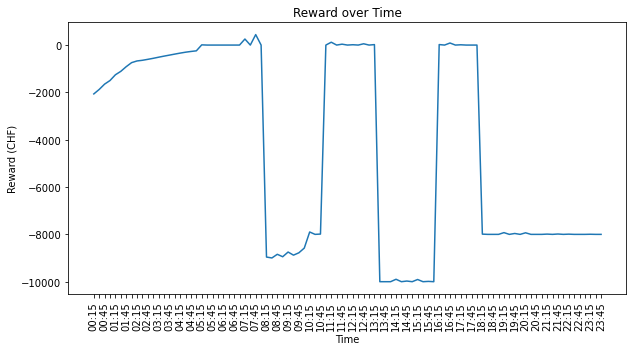

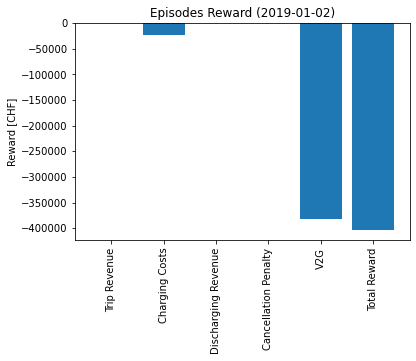

0.00040927703503712554

single positional indexer is out-of-bounds
reservation no
24525396.0
24525396.0
station_no
3997.0
vehicle id
113490

single positional indexer is out-of-bounds
reservation no
24142989.0
24142989.0
station_no
1255.0
vehicle id
115386

single positional indexer is out-of-bounds
reservation no
24525396.0
24525396.0
station_no
3997.0
vehicle id
113490

single positional indexer is out-of-bounds
reservation no
24142989.0
24142989.0
station_no
1255.0
vehicle id
115386
-------- State at time 2019-01-03 00:15:00 --------
Reward in this step: -2037.0819767100227  time:  1
0.00040927703503712554

single positional indexer is out-of-bounds
reservation no
24525328.0
24525328.0
station_no
4157.0
vehicle id
119553

single positional indexer is out-of-bounds
reservation no
24525328.0
24525328.0
station_no
4157.0
vehicle id
119553
-------- State at time 2019-01-03 00:30:00 --------
Reward in this step: -1862.6073748294014  time:  2
0.00040927703503712554

single positional inde


single positional indexer is out-of-bounds
reservation no
24525539.0
24525539.0
station_no
2339.0
vehicle id
114382

single positional indexer is out-of-bounds
reservation no
24520428.0
24520428.0
station_no
3735.0
vehicle id
116160

single positional indexer is out-of-bounds
reservation no
24522288.0
24522288.0
station_no
2702.0
vehicle id
116317

single positional indexer is out-of-bounds
reservation no
24525314.0
24525314.0
station_no
2602.0
vehicle id
116779

single positional indexer is out-of-bounds
reservation no
24524119.0
24524119.0
station_no
4264.0
vehicle id
119473
-------- State at time 2019-01-03 05:00:00 --------
Reward in this step: -265.8667274022007  time:  20
0.00040927703503712554

single positional indexer is out-of-bounds
reservation no
24525540.0
24525540.0
station_no
4185.0
vehicle id
115576

single positional indexer is out-of-bounds
reservation no
24525540.0
24525540.0
station_no
4185.0
vehicle id
115576
-------- State at time 2019-01-03 05:15:00 --------
Rew

4734.0
vehicle id
115833

single positional indexer is out-of-bounds
reservation no
24522852.0
24522852.0
station_no
2875.0
vehicle id
116078

single positional indexer is out-of-bounds
reservation no
24524260.0
24524260.0
station_no
1257.0
vehicle id
116088

single positional indexer is out-of-bounds
reservation no
24187646.0
24187646.0
station_no
1693.0
vehicle id
116115

single positional indexer is out-of-bounds
reservation no
24473523.0
24473523.0
station_no
2654.0
vehicle id
116130

single positional indexer is out-of-bounds
reservation no
24521134.0
24521134.0
station_no
2439.0
vehicle id
116212

single positional indexer is out-of-bounds
reservation no
24525561.0
24525561.0
station_no
2165.0
vehicle id
116774

single positional indexer is out-of-bounds
reservation no
24525578.0
24525578.0
station_no
1622.0
vehicle id
119460
-------- State at time 2019-01-03 06:45:00 --------
Reward in this step: 0.0  time:  27
0.0

single positional indexer is out-of-bounds
reservation no
24521

116433

single positional indexer is out-of-bounds
reservation no
24452561.0
24452561.0
station_no
3108.0
vehicle id
116667

single positional indexer is out-of-bounds
reservation no
24523872.0
24523872.0
station_no
1223.0
vehicle id
116723

single positional indexer is out-of-bounds
reservation no
24471039.0
24471039.0
station_no
2258.0
vehicle id
116825

single positional indexer is out-of-bounds
reservation no
24484143.0
24484143.0
station_no
4237.0
vehicle id
116907

single positional indexer is out-of-bounds
reservation no
24523885.0
24523885.0
station_no
1112.0
vehicle id
116986

single positional indexer is out-of-bounds
reservation no
24479534.0
24479534.0
station_no
2621.0
vehicle id
119538

single positional indexer is out-of-bounds
reservation no
24143013.0
24143013.0
station_no
2983.0
vehicle id
119562

single positional indexer is out-of-bounds
reservation no
24507971.0
24507971.0
station_no
2926.0
vehicle id
119576

single positional indexer is out-of-bounds
reservation n


single positional indexer is out-of-bounds
reservation no
24523961.0
24523961.0
station_no
4231.0
vehicle id
114692

single positional indexer is out-of-bounds
reservation no
24474092.0
24474092.0
station_no
1203.0
vehicle id
114752

single positional indexer is out-of-bounds
reservation no
24519720.0
24519720.0
station_no
2008.0
vehicle id
114877

single positional indexer is out-of-bounds
reservation no
24523119.0
24523119.0
station_no
1112.0
vehicle id
114916

single positional indexer is out-of-bounds
reservation no
24455309.0
24455309.0
station_no
1244.0
vehicle id
115024

single positional indexer is out-of-bounds
reservation no
24143005.0
24143005.0
station_no
2896.0
vehicle id
115047

single positional indexer is out-of-bounds
reservation no
24512881.0
24512881.0
station_no
3166.0
vehicle id
115189

single positional indexer is out-of-bounds
reservation no
24475513.0
24475513.0
station_no
2636.0
vehicle id
115229

single positional indexer is out-of-bounds
reservation no
24525


single positional indexer is out-of-bounds
reservation no
24524544.0
24524544.0
station_no
1131.0
vehicle id
115230

single positional indexer is out-of-bounds
reservation no
24399448.0
24399448.0
station_no
1156.0
vehicle id
115348

single positional indexer is out-of-bounds
reservation no
24524156.0
24524156.0
station_no
2734.0
vehicle id
115422

single positional indexer is out-of-bounds
reservation no
24516148.0
24516148.0
station_no
2687.0
vehicle id
115693

single positional indexer is out-of-bounds
reservation no
24523869.0
24523869.0
station_no
4669.0
vehicle id
115743

single positional indexer is out-of-bounds
reservation no
24521552.0
24521552.0
station_no
3061.0
vehicle id
115819

single positional indexer is out-of-bounds
reservation no
24467967.0
24467967.0
station_no
1077.0
vehicle id
115832

single positional indexer is out-of-bounds
reservation no
24522585.0
24522585.0
station_no
2376.0
vehicle id
116017

single positional indexer is out-of-bounds
reservation no
24525


single positional indexer is out-of-bounds
reservation no
24521983.0
24521983.0
station_no
4399.0
vehicle id
113712

single positional indexer is out-of-bounds
reservation no
24524878.0
24524878.0
station_no
4477.0
vehicle id
113976

single positional indexer is out-of-bounds
reservation no
24517308.0
24517308.0
station_no
3200.0
vehicle id
114015

single positional indexer is out-of-bounds
reservation no
24525885.0
24525885.0
station_no
3766.0
vehicle id
114149

single positional indexer is out-of-bounds
reservation no
24526028.0
24526028.0
station_no
4013.0
vehicle id
114152

single positional indexer is out-of-bounds
reservation no
24523796.0
24523796.0
station_no
1951.0
vehicle id
114197

single positional indexer is out-of-bounds
reservation no
24519976.0
24519976.0
station_no
4754.0
vehicle id
114285

single positional indexer is out-of-bounds
reservation no
24523469.0
24523469.0
station_no
3722.0
vehicle id
114365

single positional indexer is out-of-bounds
reservation no
24519

-------- State at time 2019-01-03 08:30:00 --------
Reward in this step: -8980.500475215193  time:  34
0.0

single positional indexer is out-of-bounds
reservation no
24461203.0
24461203.0
station_no
1505.0
vehicle id
113273

single positional indexer is out-of-bounds
reservation no
22902875.0
22902875.0
station_no
1164.0
vehicle id
113349

single positional indexer is out-of-bounds
reservation no
24443509.0
24443509.0
station_no
3831.0
vehicle id
113829

single positional indexer is out-of-bounds
reservation no
24526037.0
24526037.0
station_no
1517.0
vehicle id
114109

single positional indexer is out-of-bounds
reservation no
24516475.0
24516475.0
station_no
1081.0
vehicle id
114238

single positional indexer is out-of-bounds
reservation no
24488539.0
24488539.0
station_no
4204.0
vehicle id
114278

single positional indexer is out-of-bounds
reservation no
24463261.0
24463261.0
station_no
4311.0
vehicle id
114351

single positional indexer is out-of-bounds
reservation no
24525183.0
2452

0.0

single positional indexer is out-of-bounds
reservation no
24524079.0
24524079.0
station_no
1999.0
vehicle id
113200

single positional indexer is out-of-bounds
reservation no
24492980.0
24492980.0
station_no
2263.0
vehicle id
113551

single positional indexer is out-of-bounds
reservation no
24523944.0
24523944.0
station_no
4193.0
vehicle id
113559

single positional indexer is out-of-bounds
reservation no
24525333.0
24525333.0
station_no
1066.0
vehicle id
113658

single positional indexer is out-of-bounds
reservation no
24517407.0
24517407.0
station_no
3872.0
vehicle id
113664

single positional indexer is out-of-bounds
reservation no
24525861.0
24525861.0
station_no
3069.0
vehicle id
113697

single positional indexer is out-of-bounds
reservation no
24516118.0
24516118.0
station_no
2911.0
vehicle id
114070

single positional indexer is out-of-bounds
reservation no
24524254.0
24524254.0
station_no
3990.0
vehicle id
114174

single positional indexer is out-of-bounds
reservation no
2


single positional indexer is out-of-bounds
reservation no
24524433.0
24524433.0
station_no
2738.0
vehicle id
115607

single positional indexer is out-of-bounds
reservation no
24513452.0
24513452.0
station_no
4704.0
vehicle id
115632

single positional indexer is out-of-bounds
reservation no
24469707.0
24469707.0
station_no
1735.0
vehicle id
115694

single positional indexer is out-of-bounds
reservation no
24515040.0
24515040.0
station_no
2854.0
vehicle id
115723

single positional indexer is out-of-bounds
reservation no
24520138.0
24520138.0
station_no
1579.0
vehicle id
115771

single positional indexer is out-of-bounds
reservation no
24503236.0
24503236.0
station_no
3264.0
vehicle id
115795

single positional indexer is out-of-bounds
reservation no
24523153.0
24523153.0
station_no
2333.0
vehicle id
115908

single positional indexer is out-of-bounds
reservation no
24525082.0
24525082.0
station_no
4293.0
vehicle id
115989

single positional indexer is out-of-bounds
reservation no
24526


single positional indexer is out-of-bounds
reservation no
24514620.0
24514620.0
station_no
3967.0
vehicle id
115635

single positional indexer is out-of-bounds
reservation no
24523143.0
24523143.0
station_no
4534.0
vehicle id
115638

single positional indexer is out-of-bounds
reservation no
24523625.0
24523625.0
station_no
4301.0
vehicle id
115705

single positional indexer is out-of-bounds
reservation no
24504998.0
24504998.0
station_no
1091.0
vehicle id
115741

single positional indexer is out-of-bounds
reservation no
24487795.0
24487795.0
station_no
4260.0
vehicle id
115746

single positional indexer is out-of-bounds
reservation no
24526136.0
24526136.0
station_no
3199.0
vehicle id
115987

single positional indexer is out-of-bounds
reservation no
24516263.0
24516263.0
station_no
4737.0
vehicle id
116006

single positional indexer is out-of-bounds
reservation no
24526121.0
24526121.0
station_no
1875.0
vehicle id
116010

single positional indexer is out-of-bounds
reservation no
24143

24525946.0
24525946.0
station_no
3980.0
vehicle id
113933

single positional indexer is out-of-bounds
reservation no
24521283.0
24521283.0
station_no
2543.0
vehicle id
113982

single positional indexer is out-of-bounds
reservation no
24522165.0
24522165.0
station_no
4183.0
vehicle id
114008

single positional indexer is out-of-bounds
reservation no
24522095.0
24522095.0
station_no
4417.0
vehicle id
114157

single positional indexer is out-of-bounds
reservation no
24521287.0
24521287.0
station_no
1163.0
vehicle id
114298

single positional indexer is out-of-bounds
reservation no
24525206.0
24525206.0
station_no
3210.0
vehicle id
114357

single positional indexer is out-of-bounds
reservation no
24524416.0
24524416.0
station_no
1840.0
vehicle id
114373

single positional indexer is out-of-bounds
reservation no
24525863.0
24525863.0
station_no
2875.0
vehicle id
114383

single positional indexer is out-of-bounds
reservation no
24472775.0
24472775.0
station_no
3295.0
vehicle id
114421

singl


single positional indexer is out-of-bounds
reservation no
24523528.0
24523528.0
station_no
2781.0
vehicle id
114981

single positional indexer is out-of-bounds
reservation no
24526440.0
24526440.0
station_no
1531.0
vehicle id
115001

single positional indexer is out-of-bounds
reservation no
24526475.0
24526475.0
station_no
3141.0
vehicle id
115016

single positional indexer is out-of-bounds
reservation no
24498164.0
24498164.0
station_no
3141.0
vehicle id
115043

single positional indexer is out-of-bounds
reservation no
24524506.0
24524506.0
station_no
3001.0
vehicle id
115105

single positional indexer is out-of-bounds
reservation no
24524562.0
24524562.0
station_no
2104.0
vehicle id
115143

single positional indexer is out-of-bounds
reservation no
24525956.0
24525956.0
station_no
4010.0
vehicle id
115159

single positional indexer is out-of-bounds
reservation no
24526006.0
24526006.0
station_no
4585.0
vehicle id
115164

single positional indexer is out-of-bounds
reservation no
24430


single positional indexer is out-of-bounds
reservation no
24524506.0
24524506.0
station_no
3001.0
vehicle id
115105

single positional indexer is out-of-bounds
reservation no
24524562.0
24524562.0
station_no
2104.0
vehicle id
115143

single positional indexer is out-of-bounds
reservation no
24525956.0
24525956.0
station_no
4010.0
vehicle id
115159

single positional indexer is out-of-bounds
reservation no
24526006.0
24526006.0
station_no
4585.0
vehicle id
115164

single positional indexer is out-of-bounds
reservation no
24430060.0
24430060.0
station_no
4101.0
vehicle id
115221

single positional indexer is out-of-bounds
reservation no
24519485.0
24519485.0
station_no
3233.0
vehicle id
115228

single positional indexer is out-of-bounds
reservation no
24479381.0
24479381.0
station_no
2371.0
vehicle id
115305

single positional indexer is out-of-bounds
reservation no
24525275.0
24525275.0
station_no
1057.0
vehicle id
115438

single positional indexer is out-of-bounds
reservation no
24522


single positional indexer is out-of-bounds
reservation no
24513642.0
24513642.0
station_no
3888.0
vehicle id
116035

single positional indexer is out-of-bounds
reservation no
24523138.0
24523138.0
station_no
4773.0
vehicle id
116036

single positional indexer is out-of-bounds
reservation no
24523761.0
24523761.0
station_no
1552.0
vehicle id
116067

single positional indexer is out-of-bounds
reservation no
24513116.0
24513116.0
station_no
1668.0
vehicle id
116100

single positional indexer is out-of-bounds
reservation no
24518520.0
24518520.0
station_no
3151.0
vehicle id
116118

single positional indexer is out-of-bounds
reservation no
24520586.0
24520586.0
station_no
3737.0
vehicle id
116195

single positional indexer is out-of-bounds
reservation no
24499187.0
24499187.0
station_no
1091.0
vehicle id
116197

single positional indexer is out-of-bounds
reservation no
24521067.0
24521067.0
station_no
2305.0
vehicle id
116231

single positional indexer is out-of-bounds
reservation no
24524


single positional indexer is out-of-bounds
reservation no
24526579.0
24526579.0
station_no
4634.0
vehicle id
115365

single positional indexer is out-of-bounds
reservation no
24515794.0
24515794.0
station_no
1564.0
vehicle id
115437

single positional indexer is out-of-bounds
reservation no
24526290.0
24526290.0
station_no
2986.0
vehicle id
115478

single positional indexer is out-of-bounds
reservation no
24524992.0
24524992.0
station_no
2575.0
vehicle id
115533

single positional indexer is out-of-bounds
reservation no
24522183.0
24522183.0
station_no
3292.0
vehicle id
115561

single positional indexer is out-of-bounds
reservation no
24519991.0
24519991.0
station_no
4268.0
vehicle id
115704

single positional indexer is out-of-bounds
reservation no
24520874.0
24520874.0
station_no
3949.0
vehicle id
115714

single positional indexer is out-of-bounds
reservation no
24525246.0
24525246.0
station_no
4671.0
vehicle id
115749

single positional indexer is out-of-bounds
reservation no
24524


single positional indexer is out-of-bounds
reservation no
24518895.0
24518895.0
station_no
2794.0
vehicle id
113372

single positional indexer is out-of-bounds
reservation no
24524899.0
24524899.0
station_no
2073.0
vehicle id
113391

single positional indexer is out-of-bounds
reservation no
24526015.0
24526015.0
station_no
1927.0
vehicle id
113505

single positional indexer is out-of-bounds
reservation no
24519393.0
24519393.0
station_no
1543.0
vehicle id
113579

single positional indexer is out-of-bounds
reservation no
24526071.0
24526071.0
station_no
4611.0
vehicle id
113753

single positional indexer is out-of-bounds
reservation no
24526313.0
24526313.0
station_no
4424.0
vehicle id
113757

single positional indexer is out-of-bounds
reservation no
24526327.0
24526327.0
station_no
4489.0
vehicle id
113938

single positional indexer is out-of-bounds
reservation no
24521564.0
24521564.0
station_no
2377.0
vehicle id
113971

single positional indexer is out-of-bounds
reservation no
24524


single positional indexer is out-of-bounds
reservation no
24525488.0
24525488.0
station_no
2687.0
vehicle id
115652

single positional indexer is out-of-bounds
reservation no
24513772.0
24513772.0
station_no
4654.0
vehicle id
115656

single positional indexer is out-of-bounds
reservation no
24526601.0
24526601.0
station_no
3278.0
vehicle id
115724

single positional indexer is out-of-bounds
reservation no
24517338.0
24517338.0
station_no
1576.0
vehicle id
115754

single positional indexer is out-of-bounds
reservation no
24524218.0
24524218.0
station_no
3699.0
vehicle id
115776

single positional indexer is out-of-bounds
reservation no
24506270.0
24506270.0
station_no
1011.0
vehicle id
115829

single positional indexer is out-of-bounds
reservation no
24517166.0
24517166.0
station_no
2687.0
vehicle id
115912

single positional indexer is out-of-bounds
reservation no
24525919.0
24525919.0
station_no
4350.0
vehicle id
115988

single positional indexer is out-of-bounds
reservation no
24523


single positional indexer is out-of-bounds
reservation no
24526717.0
24526717.0
station_no
1656.0
vehicle id
113482

single positional indexer is out-of-bounds
reservation no
24526285.0
24526285.0
station_no
1887.0
vehicle id
113504

single positional indexer is out-of-bounds
reservation no
24520964.0
24520964.0
station_no
1842.0
vehicle id
113524

single positional indexer is out-of-bounds
reservation no
24526726.0
24526726.0
station_no
2107.0
vehicle id
113754

single positional indexer is out-of-bounds
reservation no
24523486.0
24523486.0
station_no
1181.0
vehicle id
113940

single positional indexer is out-of-bounds
reservation no
24525189.0
24525189.0
station_no
3966.0
vehicle id
114081

single positional indexer is out-of-bounds
reservation no
24526504.0
24526504.0
station_no
4472.0
vehicle id
114144

single positional indexer is out-of-bounds
reservation no
24526535.0
24526535.0
station_no
4429.0
vehicle id
114222

single positional indexer is out-of-bounds
reservation no
24526


single positional indexer is out-of-bounds
reservation no
24524205.0
24524205.0
station_no
24521978.0
vehicle id
114654

single positional indexer is out-of-bounds
reservation no
24525046.0
24525046.0
station_no
3870.0
vehicle id
114663

single positional indexer is out-of-bounds
reservation no
24526807.0
24526807.0
station_no
4716.0
vehicle id
114704

single positional indexer is out-of-bounds
reservation no
24526814.0
24526814.0
station_no
4601.0
vehicle id
114764

single positional indexer is out-of-bounds
reservation no
24526787.0
24526787.0
station_no
2795.0
vehicle id
114834

single positional indexer is out-of-bounds
reservation no
24527062.0
24527062.0
station_no
3949.0
vehicle id
114882

single positional indexer is out-of-bounds
reservation no
24522958.0
24522958.0
station_no
1625.0
vehicle id
114904

single positional indexer is out-of-bounds
reservation no
24505143.0
24505143.0
station_no
1873.0
vehicle id
114926

single positional indexer is out-of-bounds
reservation no
2


single positional indexer is out-of-bounds
reservation no
24525290.0
24525290.0
station_no
4552.0
vehicle id
116491

single positional indexer is out-of-bounds
reservation no
24526498.0
24526498.0
station_no
3205.0
vehicle id
116509

single positional indexer is out-of-bounds
reservation no
24526988.0
24526988.0
station_no
3244.0
vehicle id
116531

single positional indexer is out-of-bounds
reservation no
24526855.0
24526855.0
station_no
4566.0
vehicle id
116539

single positional indexer is out-of-bounds
reservation no
24526935.0
24526935.0
station_no
2679.0
vehicle id
116562

single positional indexer is out-of-bounds
reservation no
24527018.0
24527018.0
station_no
2886.0
vehicle id
116647

single positional indexer is out-of-bounds
reservation no
24526901.0
24526901.0
station_no
1540.0
vehicle id
116691

single positional indexer is out-of-bounds
reservation no
24525072.0
24525072.0
station_no
4298.0
vehicle id
116692

single positional indexer is out-of-bounds
reservation no
24518

2329.0
vehicle id
114388

single positional indexer is out-of-bounds
reservation no
24526805.0
24526805.0
station_no
24524730.0
vehicle id
114450

single positional indexer is out-of-bounds
reservation no
24517762.0
24517762.0
station_no
3720.0
vehicle id
114698

single positional indexer is out-of-bounds
reservation no
24524061.0
24524061.0
station_no
2877.0
vehicle id
114797

single positional indexer is out-of-bounds
reservation no
24524638.0
24524638.0
station_no
1212.0
vehicle id
114799

single positional indexer is out-of-bounds
reservation no
24526897.0
24526897.0
station_no
4298.0
vehicle id
114859

single positional indexer is out-of-bounds
reservation no
24525551.0
24525551.0
station_no
4655.0
vehicle id
114918

single positional indexer is out-of-bounds
reservation no
24524817.0
24524817.0
station_no
3235.0
vehicle id
115156

single positional indexer is out-of-bounds
reservation no
24523994.0
24523994.0
station_no
2914.0
vehicle id
115308

single positional indexer is out-o

24527346.0
station_no
3018.0
vehicle id
114342

single positional indexer is out-of-bounds
reservation no
24418586.0
24418586.0
station_no
2975.0
vehicle id
114361

single positional indexer is out-of-bounds
reservation no
24527035.0
24527035.0
station_no
4198.0
vehicle id
114423

single positional indexer is out-of-bounds
reservation no
24526762.0
24526762.0
station_no
1512.0
vehicle id
114531

single positional indexer is out-of-bounds
reservation no
24527146.0
24527146.0
station_no
4498.0
vehicle id
114541

single positional indexer is out-of-bounds
reservation no
24525665.0
24525665.0
station_no
1084.0
vehicle id
114589

single positional indexer is out-of-bounds
reservation no
24521353.0
24521353.0
station_no
2687.0
vehicle id
114620

single positional indexer is out-of-bounds
reservation no
24525116.0
24525116.0
station_no
2333.0
vehicle id
114683

single positional indexer is out-of-bounds
reservation no
24525040.0
24525040.0
station_no
2528.0
vehicle id
114807

single positiona


single positional indexer is out-of-bounds
reservation no
24527265.0
24527265.0
station_no
1258.0
vehicle id
115592

single positional indexer is out-of-bounds
reservation no
24527314.0
24527314.0
station_no
1653.0
vehicle id
115598

single positional indexer is out-of-bounds
reservation no
24524457.0
24524457.0
station_no
3059.0
vehicle id
115641

single positional indexer is out-of-bounds
reservation no
24518274.0
24518274.0
station_no
3808.0
vehicle id
115783

single positional indexer is out-of-bounds
reservation no
24523570.0
24523570.0
station_no
1229.0
vehicle id
115787

single positional indexer is out-of-bounds
reservation no
24525146.0
24525146.0
station_no
3737.0
vehicle id
115800

single positional indexer is out-of-bounds
reservation no
24526863.0
24526863.0
station_no
4512.0
vehicle id
115979

single positional indexer is out-of-bounds
reservation no
24526848.0
24526848.0
station_no
2882.0
vehicle id
116156

single positional indexer is out-of-bounds
reservation no
24527

station_no
3936.0
vehicle id
116935

single positional indexer is out-of-bounds
reservation no
24525997.0
24525997.0
station_no
2015.0
vehicle id
118195

single positional indexer is out-of-bounds
reservation no
24527408.0
24527408.0
station_no
4701.0
vehicle id
119435

single positional indexer is out-of-bounds
reservation no
24521976.0
24521976.0
station_no
1290.0
vehicle id
119463

single positional indexer is out-of-bounds
reservation no
24522266.0
24522266.0
station_no
3833.0
vehicle id
119469

single positional indexer is out-of-bounds
reservation no
24527300.0
24527300.0
station_no
2896.0
vehicle id
119484

single positional indexer is out-of-bounds
reservation no
24527355.0
24527355.0
station_no
2500.0
vehicle id
119488

single positional indexer is out-of-bounds
reservation no
24527187.0
24527187.0
station_no
1086.0
vehicle id
119546
-------- State at time 2019-01-03 12:15:00 --------
Reward in this step: 14.0  time:  49
0.0

single positional indexer is out-of-bounds
reservat


single positional indexer is out-of-bounds
reservation no
24525553.0
24525553.0
station_no
4097.0
vehicle id
116046

single positional indexer is out-of-bounds
reservation no
24523878.0
24523878.0
station_no
1512.0
vehicle id
116217

single positional indexer is out-of-bounds
reservation no
24527538.0
24527538.0
station_no
3837.0
vehicle id
116279

single positional indexer is out-of-bounds
reservation no
24527477.0
24527477.0
station_no
2333.0
vehicle id
116324

single positional indexer is out-of-bounds
reservation no
24525010.0
24525010.0
station_no
2687.0
vehicle id
116415

single positional indexer is out-of-bounds
reservation no
24514627.0
24514627.0
station_no
2850.0
vehicle id
116477

single positional indexer is out-of-bounds
reservation no
24527561.0
24527561.0
station_no
3259.0
vehicle id
116760

single positional indexer is out-of-bounds
reservation no
24513137.0
24513137.0
station_no
3085.0
vehicle id
116777

single positional indexer is out-of-bounds
reservation no
24523


single positional indexer is out-of-bounds
reservation no
24527005.0
24527005.0
station_no
1767.0
vehicle id
114635

single positional indexer is out-of-bounds
reservation no
24527569.0
24527569.0
station_no
4104.0
vehicle id
114700

single positional indexer is out-of-bounds
reservation no
24524941.0
24524941.0
station_no
1204.0
vehicle id
114743

single positional indexer is out-of-bounds
reservation no
24527628.0
24527628.0
station_no
4298.0
vehicle id
114870

single positional indexer is out-of-bounds
reservation no
24526665.0
24526665.0
station_no
4543.0
vehicle id
114936

single positional indexer is out-of-bounds
reservation no
24491792.0
24491792.0
station_no
24526475.0
vehicle id
115016

single positional indexer is out-of-bounds
reservation no
24501517.0
24501517.0
station_no
3808.0
vehicle id
115038

single positional indexer is out-of-bounds
reservation no
24521977.0
24521977.0
station_no
4551.0
vehicle id
115129

single positional indexer is out-of-bounds
reservation no
2


single positional indexer is out-of-bounds
reservation no
24524231.0
24524231.0
station_no
4388.0
vehicle id
113129

single positional indexer is out-of-bounds
reservation no
24527507.0
24527507.0
station_no
2952.0
vehicle id
113468

single positional indexer is out-of-bounds
reservation no
24524568.0
24524568.0
station_no
4407.0
vehicle id
113833

single positional indexer is out-of-bounds
reservation no
24526406.0
24526406.0
station_no
3075.0
vehicle id
113975

single positional indexer is out-of-bounds
reservation no
24527651.0
24527651.0
station_no
1673.0
vehicle id
114004

single positional indexer is out-of-bounds
reservation no
24526676.0
24526676.0
station_no
2956.0
vehicle id
114085

single positional indexer is out-of-bounds
reservation no
24525213.0
24525213.0
station_no
1975.0
vehicle id
114122

single positional indexer is out-of-bounds
reservation no
24527525.0
24527525.0
station_no
4343.0
vehicle id
114130

single positional indexer is out-of-bounds
reservation no
24526


single positional indexer is out-of-bounds
reservation no
24527576.0
24527576.0
station_no
2447.0
vehicle id
115566

single positional indexer is out-of-bounds
reservation no
24525605.0
24525605.0
station_no
1633.0
vehicle id
115599

single positional indexer is out-of-bounds
reservation no
24527306.0
24527306.0
station_no
1223.0
vehicle id
115682

single positional indexer is out-of-bounds
reservation no
24527135.0
24527135.0
station_no
5226.0
vehicle id
115712

single positional indexer is out-of-bounds
reservation no
24525446.0
24525446.0
station_no
4320.0
vehicle id
115762

single positional indexer is out-of-bounds
reservation no
24526829.0
24526829.0
station_no
4353.0
vehicle id
115818

single positional indexer is out-of-bounds
reservation no
24524834.0
24524834.0
station_no
3216.0
vehicle id
115823

single positional indexer is out-of-bounds
reservation no
24401123.0
24401123.0
station_no
2333.0
vehicle id
115908

single positional indexer is out-of-bounds
reservation no
24527


single positional indexer is out-of-bounds
reservation no
24527434.0
24527434.0
station_no
2962.0
vehicle id
113241

single positional indexer is out-of-bounds
reservation no
24518732.0
24518732.0
station_no
24527340.0
vehicle id
113268

single positional indexer is out-of-bounds
reservation no
24521591.0
24521591.0
station_no
2954.0
vehicle id
113270

single positional indexer is out-of-bounds
reservation no
24484523.0
24484523.0
station_no
1066.0
vehicle id
113328

single positional indexer is out-of-bounds
reservation no
24527832.0
24527832.0
station_no
1594.0
vehicle id
113515

single positional indexer is out-of-bounds
reservation no
24522412.0
24522412.0
station_no
2356.0
vehicle id
113523

single positional indexer is out-of-bounds
reservation no
24526720.0
24526720.0
station_no
1842.0
vehicle id
113524

single positional indexer is out-of-bounds
reservation no
24522334.0
24522334.0
station_no
2985.0
vehicle id
113536

single positional indexer is out-of-bounds
reservation no
2

station_no
1531.0
vehicle id
115722

single positional indexer is out-of-bounds
reservation no
24527360.0
24527360.0
station_no
4811.0
vehicle id
115725

single positional indexer is out-of-bounds
reservation no
24526383.0
24526383.0
station_no
1623.0
vehicle id
115747

single positional indexer is out-of-bounds
reservation no
24527007.0
24527007.0
station_no
1633.0
vehicle id
115992

single positional indexer is out-of-bounds
reservation no
24523840.0
24523840.0
station_no
1914.0
vehicle id
116004

single positional indexer is out-of-bounds
reservation no
24526288.0
24526288.0
station_no
4737.0
vehicle id
116006

single positional indexer is out-of-bounds
reservation no
24527678.0
24527678.0
station_no
1291.0
vehicle id
116082

single positional indexer is out-of-bounds
reservation no
24527613.0
24527613.0
station_no
1693.0
vehicle id
116115

single positional indexer is out-of-bounds
reservation no
24526523.0
24526523.0
station_no
3026.0
vehicle id
116131

single positional indexer i


single positional indexer is out-of-bounds
reservation no
24523580.0
24523580.0
station_no
3291.0
vehicle id
115248

single positional indexer is out-of-bounds
reservation no
24524587.0
24524587.0
station_no
4636.0
vehicle id
115254

single positional indexer is out-of-bounds
reservation no
24527627.0
24527627.0
station_no
2840.0
vehicle id
115274

single positional indexer is out-of-bounds
reservation no
24504438.0
24504438.0
station_no
4524.0
vehicle id
115325

single positional indexer is out-of-bounds
reservation no
24527693.0
24527693.0
station_no
3946.0
vehicle id
115511

single positional indexer is out-of-bounds
reservation no
24527796.0
24527796.0
station_no
1066.0
vehicle id
115535

single positional indexer is out-of-bounds
reservation no
24523484.0
24523484.0
station_no
2781.0
vehicle id
115544

single positional indexer is out-of-bounds
reservation no
24517000.0
24517000.0
station_no
24522346.0
vehicle id
115640

single positional indexer is out-of-bounds
reservation no
2

single positional indexer is out-of-bounds
reservation no
24528008.0
24528008.0
station_no
1864.0
vehicle id
114306

single positional indexer is out-of-bounds
reservation no
24527812.0
24527812.0
station_no
1291.0
vehicle id
114367

single positional indexer is out-of-bounds
reservation no
24527943.0
24527943.0
station_no
4662.0
vehicle id
114372

single positional indexer is out-of-bounds
reservation no
24524399.0
24524399.0
station_no
1984.0
vehicle id
114374

single positional indexer is out-of-bounds
reservation no
24527641.0
24527641.0
station_no
4546.0
vehicle id
114403

single positional indexer is out-of-bounds
reservation no
24527121.0
24527121.0
station_no
2056.0
vehicle id
114427

single positional indexer is out-of-bounds
reservation no
24526439.0
24526439.0
station_no
4364.0
vehicle id
114686

single positional indexer is out-of-bounds
reservation no
24525077.0
24525077.0
station_no
3953.0
vehicle id
114744

single positional indexer is out-of-bounds
reservation no
245236

24528058.0
station_no
1887.0
vehicle id
113504

single positional indexer is out-of-bounds
reservation no
24526580.0
24526580.0
station_no
4015.0
vehicle id
113721

single positional indexer is out-of-bounds
reservation no
24527548.0
24527548.0
station_no
4303.0
vehicle id
113996

single positional indexer is out-of-bounds
reservation no
24527108.0
24527108.0
station_no
4474.0
vehicle id
114286

single positional indexer is out-of-bounds
reservation no
24525906.0
24525906.0
station_no
2931.0
vehicle id
114301

single positional indexer is out-of-bounds
reservation no
24527773.0
24527773.0
station_no
1288.0
vehicle id
114468

single positional indexer is out-of-bounds
reservation no
24527616.0
24527616.0
station_no
1925.0
vehicle id
114470

single positional indexer is out-of-bounds
reservation no
24526822.0
24526822.0
station_no
4496.0
vehicle id
114503

single positional indexer is out-of-bounds
reservation no
24527663.0
24527663.0
station_no
1697.0
vehicle id
114637

single positiona

115027

single positional indexer is out-of-bounds
reservation no
24526373.0
24526373.0
station_no
3971.0
vehicle id
115192

single positional indexer is out-of-bounds
reservation no
24524850.0
24524850.0
station_no
3998.0
vehicle id
115211

single positional indexer is out-of-bounds
reservation no
24528154.0
24528154.0
station_no
1840.0
vehicle id
115289

single positional indexer is out-of-bounds
reservation no
24526857.0
24526857.0
station_no
4758.0
vehicle id
115296

single positional indexer is out-of-bounds
reservation no
24527857.0
24527857.0
station_no
3154.0
vehicle id
115306

single positional indexer is out-of-bounds
reservation no
24527181.0
24527181.0
station_no
4724.0
vehicle id
115429

single positional indexer is out-of-bounds
reservation no
24527930.0
24527930.0
station_no
1925.0
vehicle id
115482

single positional indexer is out-of-bounds
reservation no
24527956.0
24527956.0
station_no
2077.0
vehicle id
115528

single positional indexer is out-of-bounds
reservation n


single positional indexer is out-of-bounds
reservation no
24524229.0
24524229.0
station_no
1092.0
vehicle id
114369

single positional indexer is out-of-bounds
reservation no
24528300.0
24528300.0
station_no
2902.0
vehicle id
114462

single positional indexer is out-of-bounds
reservation no
24528046.0
24528046.0
station_no
4069.0
vehicle id
114490

single positional indexer is out-of-bounds
reservation no
24528301.0
24528301.0
station_no
1200.0
vehicle id
114537

single positional indexer is out-of-bounds
reservation no
24526138.0
24526138.0
station_no
1025.0
vehicle id
114591

single positional indexer is out-of-bounds
reservation no
24528292.0
24528292.0
station_no
2104.0
vehicle id
114616

single positional indexer is out-of-bounds
reservation no
24527760.0
24527760.0
station_no
1212.0
vehicle id
114640

single positional indexer is out-of-bounds
reservation no
24528141.0
24528141.0
station_no
1223.0
vehicle id
114808

single positional indexer is out-of-bounds
reservation no
24526


single positional indexer is out-of-bounds
reservation no
24525514.0
24525514.0
station_no
1235.0
vehicle id
114778

single positional indexer is out-of-bounds
reservation no
24528322.0
24528322.0
station_no
1154.0
vehicle id
114824

single positional indexer is out-of-bounds
reservation no
24528156.0
24528156.0
station_no
4298.0
vehicle id
114859

single positional indexer is out-of-bounds
reservation no
24517267.0
24517267.0
station_no
24524312.0
vehicle id
114935

single positional indexer is out-of-bounds
reservation no
24168883.0
24168883.0
station_no
2996.0
vehicle id
114986

single positional indexer is out-of-bounds
reservation no
24520757.0
24520757.0
station_no
1264.0
vehicle id
115018

single positional indexer is out-of-bounds
reservation no
24522917.0
24522917.0
station_no
1581.0
vehicle id
115037

single positional indexer is out-of-bounds
reservation no
24528097.0
24528097.0
station_no
2737.0
vehicle id
115130

single positional indexer is out-of-bounds
reservation no
2


single positional indexer is out-of-bounds
reservation no
24528108.0
24528108.0
station_no
3849.0
vehicle id
115523

single positional indexer is out-of-bounds
reservation no
24528323.0
24528323.0
station_no
1075.0
vehicle id
115650

single positional indexer is out-of-bounds
reservation no
24528464.0
24528464.0
station_no
1024.0
vehicle id
115737

single positional indexer is out-of-bounds
reservation no
24505564.0
24505564.0
station_no
1735.0
vehicle id
115805

single positional indexer is out-of-bounds
reservation no
24524617.0
24524617.0
station_no
1596.0
vehicle id
115816

single positional indexer is out-of-bounds
reservation no
24527491.0
24527491.0
station_no
4743.0
vehicle id
115994

single positional indexer is out-of-bounds
reservation no
24528452.0
24528452.0
station_no
4721.0
vehicle id
116012

single positional indexer is out-of-bounds
reservation no
24528582.0
24528582.0
station_no
2376.0
vehicle id
116017

single positional indexer is out-of-bounds
reservation no
24526


single positional indexer is out-of-bounds
reservation no
24528574.0
24528574.0
station_no
4201.0
vehicle id
114713

single positional indexer is out-of-bounds
reservation no
24521980.0
24521980.0
station_no
1625.0
vehicle id
114739

single positional indexer is out-of-bounds
reservation no
24528699.0
24528699.0
station_no
1204.0
vehicle id
114743

single positional indexer is out-of-bounds
reservation no
24528672.0
24528672.0
station_no
1203.0
vehicle id
114752

single positional indexer is out-of-bounds
reservation no
24528085.0
24528085.0
station_no
2795.0
vehicle id
114834

single positional indexer is out-of-bounds
reservation no
24521725.0
24521725.0
station_no
1226.0
vehicle id
114894

single positional indexer is out-of-bounds
reservation no
24519751.0
24519751.0
station_no
24527917.0
vehicle id
114929

single positional indexer is out-of-bounds
reservation no
24524541.0
24524541.0
station_no
2107.0
vehicle id
114968

single positional indexer is out-of-bounds
reservation no
2

24528619.0
24528619.0
station_no
1244.0
vehicle id
114832

single positional indexer is out-of-bounds
reservation no
24527808.0
24527808.0
station_no
4543.0
vehicle id
114936

single positional indexer is out-of-bounds
reservation no
24518164.0
24518164.0
station_no
2323.0
vehicle id
115008

single positional indexer is out-of-bounds
reservation no
24528744.0
24528744.0
station_no
4789.0
vehicle id
115197

single positional indexer is out-of-bounds
reservation no
24526568.0
24526568.0
station_no
2587.0
vehicle id
115205

single positional indexer is out-of-bounds
reservation no
24528821.0
24528821.0
station_no
2687.0
vehicle id
115374

single positional indexer is out-of-bounds
reservation no
24528633.0
24528633.0
station_no
4091.0
vehicle id
115539

single positional indexer is out-of-bounds
reservation no
24521874.0
24521874.0
station_no
2447.0
vehicle id
115566

single positional indexer is out-of-bounds
reservation no
24525581.0
24525581.0
station_no
1221.0
vehicle id
115588

singl


single positional indexer is out-of-bounds
reservation no
24521708.0
24521708.0
station_no
24527631.0
vehicle id
115107

single positional indexer is out-of-bounds
reservation no
24526612.0
24526612.0
station_no
4301.0
vehicle id
115705

single positional indexer is out-of-bounds
reservation no
24527860.0
24527860.0
station_no
2877.0
vehicle id
115739

single positional indexer is out-of-bounds
reservation no
24526403.0
24526403.0
station_no
2159.0
vehicle id
116068

single positional indexer is out-of-bounds
reservation no
24528715.0
24528715.0
station_no
1696.0
vehicle id
116076

single positional indexer is out-of-bounds
reservation no
24528117.0
24528117.0
station_no
5000.0
vehicle id
116198

single positional indexer is out-of-bounds
reservation no
24526263.0
24526263.0
station_no
1290.0
vehicle id
116204

single positional indexer is out-of-bounds
reservation no
24528826.0
24528826.0
station_no
24528185.0
vehicle id
116281

single positional indexer is out-of-bounds
reservation 


single positional indexer is out-of-bounds
reservation no
24524473.0
24524473.0
station_no
3737.0
vehicle id
119673

single positional indexer is out-of-bounds
reservation no
24528913.0
24528913.0
station_no
2500.0
vehicle id
120363

single positional indexer is out-of-bounds
reservation no
24528932.0
24528932.0
station_no
5249.0
vehicle id
122802

single positional indexer is out-of-bounds
reservation no
24514432.0
24514432.0
station_no
1843.0
vehicle id
113017

single positional indexer is out-of-bounds
reservation no
24528811.0
24528811.0
station_no
2948.0
vehicle id
113239

single positional indexer is out-of-bounds
reservation no
24528662.0
24528662.0
station_no
4580.0
vehicle id
113746

single positional indexer is out-of-bounds
reservation no
24528920.0
24528920.0
station_no
4424.0
vehicle id
113757

single positional indexer is out-of-bounds
reservation no
24527738.0
24527738.0
station_no
3235.0
vehicle id
113892

single positional indexer is out-of-bounds
reservation no
24527

4003.0
vehicle id
114110

single positional indexer is out-of-bounds
reservation no
24528775.0
24528775.0
station_no
1163.0
vehicle id
114298

single positional indexer is out-of-bounds
reservation no
24529082.0
24529082.0
station_no
4114.0
vehicle id
114501

single positional indexer is out-of-bounds
reservation no
24529073.0
24529073.0
station_no
1244.0
vehicle id
114646

single positional indexer is out-of-bounds
reservation no
24527723.0
24527723.0
station_no
1659.0
vehicle id
114650

single positional indexer is out-of-bounds
reservation no
24528966.0
24528966.0
station_no
1633.0
vehicle id
114850

single positional indexer is out-of-bounds
reservation no
24527935.0
24527935.0
station_no
2769.0
vehicle id
114867

single positional indexer is out-of-bounds
reservation no
24528961.0
24528961.0
station_no
1149.0
vehicle id
114895

single positional indexer is out-of-bounds
reservation no
24524900.0
24524900.0
station_no
4361.0
vehicle id
114933

single positional indexer is out-of-bo


single positional indexer is out-of-bounds
reservation no
24529007.0
24529007.0
station_no
4721.0
vehicle id
116012

single positional indexer is out-of-bounds
reservation no
24526305.0
24526305.0
station_no
3256.0
vehicle id
116049

single positional indexer is out-of-bounds
reservation no
24529094.0
24529094.0
station_no
4715.0
vehicle id
116086

single positional indexer is out-of-bounds
reservation no
24529104.0
24529104.0
station_no
2990.0
vehicle id
116319

single positional indexer is out-of-bounds
reservation no
24527244.0
24527244.0
station_no
1091.0
vehicle id
116340

single positional indexer is out-of-bounds
reservation no
24527806.0
24527806.0
station_no
4741.0
vehicle id
116546

single positional indexer is out-of-bounds
reservation no
24524025.0
24524025.0
station_no
1633.0
vehicle id
116670

single positional indexer is out-of-bounds
reservation no
24529088.0
24529088.0
station_no
3085.0
vehicle id
116777

single positional indexer is out-of-bounds
reservation no
24529


single positional indexer is out-of-bounds
reservation no
24527604.0
24527604.0
station_no
4114.0
vehicle id
119671
-------- State at time 2019-01-03 17:15:00 --------
Reward in this step: 12.0  time:  69
0.0

single positional indexer is out-of-bounds
reservation no
24528909.0
24528909.0
station_no
2997.0
vehicle id
113540

single positional indexer is out-of-bounds
reservation no
24527741.0
24527741.0
station_no
4193.0
vehicle id
113559

single positional indexer is out-of-bounds
reservation no
24529269.0
24529269.0
station_no
3884.0
vehicle id
113722

single positional indexer is out-of-bounds
reservation no
24524341.0
24524341.0
station_no
2959.0
vehicle id
113997

single positional indexer is out-of-bounds
reservation no
24527124.0
24527124.0
station_no
3200.0
vehicle id
114015

single positional indexer is out-of-bounds
reservation no
24529131.0
24529131.0
station_no
3215.0
vehicle id
114072

single positional indexer is out-of-bounds
reservation no
24529228.0
24529228.0
station


single positional indexer is out-of-bounds
reservation no
24529222.0
24529222.0
station_no
2257.0
vehicle id
115207

single positional indexer is out-of-bounds
reservation no
24522547.0
24522547.0
station_no
24527857.0
vehicle id
115306

single positional indexer is out-of-bounds
reservation no
24529338.0
24529338.0
station_no
1248.0
vehicle id
115352

single positional indexer is out-of-bounds
reservation no
24529120.0
24529120.0
station_no
4185.0
vehicle id
115576

single positional indexer is out-of-bounds
reservation no
24529359.0
24529359.0
station_no
4660.0
vehicle id
115817

single positional indexer is out-of-bounds
reservation no
24529290.0
24529290.0
station_no
1241.0
vehicle id
115826

single positional indexer is out-of-bounds
reservation no
24528634.0
24528634.0
station_no
5000.0
vehicle id
116022

single positional indexer is out-of-bounds
reservation no
24528627.0
24528627.0
station_no
4546.0
vehicle id
116053

single positional indexer is out-of-bounds
reservation no
2

single positional indexer is out-of-bounds
reservation no
24527887.0
24527887.0
station_no
3295.0
vehicle id
115212

single positional indexer is out-of-bounds
reservation no
24529368.0
24529368.0
station_no
4596.0
vehicle id
115403

single positional indexer is out-of-bounds
reservation no
24527460.0
24527460.0
station_no
1511.0
vehicle id
115447

single positional indexer is out-of-bounds
reservation no
24529128.0
24529128.0
station_no
4623.0
vehicle id
115450

single positional indexer is out-of-bounds
reservation no
24524709.0
24524709.0
station_no
1296.0
vehicle id
115568

single positional indexer is out-of-bounds
reservation no
24501999.0
24501999.0
station_no
4289.0
vehicle id
115594

single positional indexer is out-of-bounds
reservation no
24529372.0
24529372.0
station_no
4391.0
vehicle id
115608

single positional indexer is out-of-bounds
reservation no
24529367.0
24529367.0
station_no
2156.0
vehicle id
115622

single positional indexer is out-of-bounds
reservation no
245291


single positional indexer is out-of-bounds
reservation no
24528842.0
24528842.0
station_no
4298.0
vehicle id
114859

single positional indexer is out-of-bounds
reservation no
24529510.0
24529510.0
station_no
3808.0
vehicle id
114862

single positional indexer is out-of-bounds
reservation no
24529138.0
24529138.0
station_no
4656.0
vehicle id
114919

single positional indexer is out-of-bounds
reservation no
24524780.0
24524780.0
station_no
1241.0
vehicle id
114974

single positional indexer is out-of-bounds
reservation no
24529457.0
24529457.0
station_no
2130.0
vehicle id
115174

single positional indexer is out-of-bounds
reservation no
24523346.0
24523346.0
station_no
3725.0
vehicle id
115250

single positional indexer is out-of-bounds
reservation no
24524091.0
24524091.0
station_no
4617.0
vehicle id
115251

single positional indexer is out-of-bounds
reservation no
24529108.0
24529108.0
station_no
4716.0
vehicle id
115284

single positional indexer is out-of-bounds
reservation no
24524

1244.0
vehicle id
114832

single positional indexer is out-of-bounds
reservation no
24528045.0
24528045.0
station_no
4771.0
vehicle id
114879

single positional indexer is out-of-bounds
reservation no
24529559.0
24529559.0
station_no
1205.0
vehicle id
114889

single positional indexer is out-of-bounds
reservation no
24528648.0
24528648.0
station_no
4567.0
vehicle id
114932

single positional indexer is out-of-bounds
reservation no
24529548.0
24529548.0
station_no
3724.0
vehicle id
115717

single positional indexer is out-of-bounds
reservation no
24529500.0
24529500.0
station_no
4738.0
vehicle id
115993

single positional indexer is out-of-bounds
reservation no
24529497.0
24529497.0
station_no
3093.0
vehicle id
116060

single positional indexer is out-of-bounds
reservation no
24525253.0
24525253.0
station_no
1668.0
vehicle id
116100

single positional indexer is out-of-bounds
reservation no
24529555.0
24529555.0
station_no
2661.0
vehicle id
116254

single positional indexer is out-of-bo

reservation no
24529504.0
24529504.0
station_no
1734.0
vehicle id
114206

single positional indexer is out-of-bounds
reservation no
24395106.0
24395106.0
station_no
1025.0
vehicle id
114453

single positional indexer is out-of-bounds
reservation no
24528661.0
24528661.0
station_no
4791.0
vehicle id
114496

single positional indexer is out-of-bounds
reservation no
24143007.0
24143007.0
station_no
4560.0
vehicle id
114696

single positional indexer is out-of-bounds
reservation no
24449023.0
24449023.0
station_no
1131.0
vehicle id
115230

single positional indexer is out-of-bounds
reservation no
24528787.0
24528787.0
station_no
1086.0
vehicle id
115333

single positional indexer is out-of-bounds
reservation no
24522194.0
24522194.0
station_no
2170.0
vehicle id
115357

single positional indexer is out-of-bounds
reservation no
24521993.0
24521993.0
station_no
3061.0
vehicle id
115819

single positional indexer is out-of-bounds
reservation no
24529682.0
24529682.0
station_no
4155.0
vehicle i


single positional indexer is out-of-bounds
reservation no
24529745.0
24529745.0
station_no
3282.0
vehicle id
113502

single positional indexer is out-of-bounds
reservation no
24529873.0
24529873.0
station_no
2944.0
vehicle id
114475

single positional indexer is out-of-bounds
reservation no
24529567.0
24529567.0
station_no
24529469.0
vehicle id
114818

single positional indexer is out-of-bounds
reservation no
24529796.0
24529796.0
station_no
2886.0
vehicle id
114874

single positional indexer is out-of-bounds
reservation no
24529841.0
24529841.0
station_no
1505.0
vehicle id
115295

single positional indexer is out-of-bounds
reservation no
24529849.0
24529849.0
station_no
2653.0
vehicle id
115586

single positional indexer is out-of-bounds
reservation no
24529725.0
24529725.0
station_no
3216.0
vehicle id
115823

single positional indexer is out-of-bounds
reservation no
24511493.0
24511493.0
station_no
1535.0
vehicle id
116062

single positional indexer is out-of-bounds
reservation no
2


single positional indexer is out-of-bounds
reservation no
24523909.0
24523909.0
station_no
1153.0
vehicle id
114111

single positional indexer is out-of-bounds
reservation no
24528604.0
24528604.0
station_no
1069.0
vehicle id
114178

single positional indexer is out-of-bounds
reservation no
24530073.0
24530073.0
station_no
2795.0
vehicle id
114798

single positional indexer is out-of-bounds
reservation no
24530119.0
24530119.0
station_no
1697.0
vehicle id
115728

single positional indexer is out-of-bounds
reservation no
24528624.0
24528624.0
station_no
1151.0
vehicle id
116796

single positional indexer is out-of-bounds
reservation no
24530101.0
24530101.0
station_no
1566.0
vehicle id
116959

single positional indexer is out-of-bounds
reservation no
24495482.0
24495482.0
station_no
1843.0
vehicle id
119479
-------- State at time 2019-01-03 22:00:00 --------
Reward in this step: 0.0  time:  88
0.0

single positional indexer is out-of-bounds
reservation no
24529846.0
24529846.0
station_

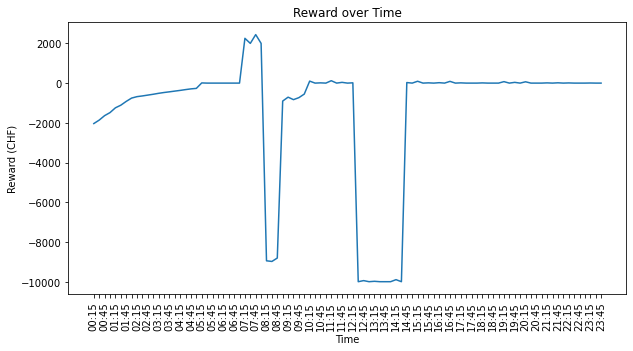

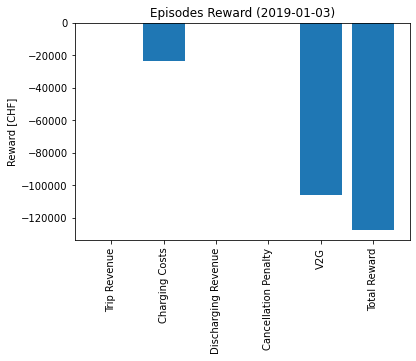

3.8256298305339165e-05

single positional indexer is out-of-bounds
reservation no
24305110.0
24305110.0
station_no
1255.0
vehicle id
114295

single positional indexer is out-of-bounds
reservation no
24530300.0
24530300.0
station_no
1091.0
vehicle id
116469

single positional indexer is out-of-bounds
reservation no
24305110.0
24305110.0
station_no
1255.0
vehicle id
114295

single positional indexer is out-of-bounds
reservation no
24530300.0
24530300.0
station_no
1091.0
vehicle id
116469
-------- State at time 2019-01-04 00:15:00 --------
Reward in this step: -2033.5797271072774  time:  1
3.8256298305339165e-05

single positional indexer is out-of-bounds
reservation no
24529979.0
24529979.0
station_no
4231.0
vehicle id
114692

single positional indexer is out-of-bounds
reservation no
24530436.0
24530436.0
station_no
4157.0
vehicle id
119553

single positional indexer is out-of-bounds
reservation no
24529979.0
24529979.0
station_no
4231.0
vehicle id
114692

single positional indexer is ou


single positional indexer is out-of-bounds
reservation no
24530529.0
24530529.0
station_no
4266.0
vehicle id
115116

single positional indexer is out-of-bounds
reservation no
24530517.0
24530517.0
station_no
4185.0
vehicle id
115576

single positional indexer is out-of-bounds
reservation no
24524436.0
24524436.0
station_no
4348.0
vehicle id
116487

single positional indexer is out-of-bounds
reservation no
24529566.0
24529566.0
station_no
1156.0
vehicle id
115009

single positional indexer is out-of-bounds
reservation no
24530529.0
24530529.0
station_no
4266.0
vehicle id
115116

single positional indexer is out-of-bounds
reservation no
24530517.0
24530517.0
station_no
4185.0
vehicle id
115576

single positional indexer is out-of-bounds
reservation no
24524436.0
24524436.0
station_no
4348.0
vehicle id
116487
-------- State at time 2019-01-04 05:15:00 --------
Reward in this step: 9.0  time:  21
3.8256298305339165e-05

single positional indexer is out-of-bounds
reservation no
24514908.0


AssertionError: Vehicle SOC is wrong.

In [53]:
# number of days to simulate 
nr_iterations = 8

#env = CarsharingEnv(stations, vehicles, planned_bookings = False, plot_state = False)
env = CarsharingEnv(stations, vehicles, planned_bookings = False, plot_state = False)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0


# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    #sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    #data = pd.read_sql(sql, engine)
    
    assert data["vehicle_no"].tolist() == vehicles["vehicle_no"].tolist(), "Vehicle information is wrong."
    
    # iteration for each day
    for day in range(98,676,96):
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        #date = pd.to_datetime(data.columns[day-97])
       
        # load reservations of current day, create indices
        #sql = "SELECT * FROM msc_2023_dominik.reservations_no_service_discrete WHERE reservationfrom_discrete_date = '{}' or drive_firststart_discrete_date = '{}' ORDER BY reservationfrom_discrete".format(date, date)
        #reservations = pd.read_sql(sql, engine)
        #reservations.set_index(['vehicle_no', 'reservationfrom_daytime', 'syscreatedate_daytime'], inplace=True, drop=False)

        # get discete data of day
        daily_data = data.iloc[:,day-97:day]   
        
        # reset day at begining of new episode (day)
        s = env.reset(daily_data, reservations)
        
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            ### action ###
            if counter < 20:
                act = np.ones(len(vehicles))
            if counter >= 20 and counter <= 32:
                act = np.zeros(len(vehicles))
                act[:1000] = 2
            if counter >= 32 and counter <= 40:
                act = np.ones(len(vehicles))
            if counter >= 40:
                act = np.zeros(len(vehicles))
                
            #act = np.ones(nr_vehicles)# always charge all vehicles
            # act = np.full(nr_vehicles, 2) # always discharge all vehicles
            # act = np.zeros(nr_vehicles) # do nothing
            
            # proceed one time step
            s, rew, daily_data, done, _ = env.step(act, daily_data, reservations, electricity_price)
            
            # get timestep statistics 
            env.render(daily_data)
            
            print("Reward in this step:", rew, " time: ", env.t)
            counter +=1
        
        # summary statistics of episode (day)
        env.episode_summary_statistics(daily_data)
        count += 1